<b><font size="6"> Data Mining Project - Group XX 2025/2026 </font></b><br><br>
<i> <font size="4"> Amazing International Airlines Inc. (AIAI)</font></i>

`Group XX`

20250405 Ana Macedo <br>
20250453 Lourenço Silva <br>
20250380 Maria Fonseca <br>

# Import Libraries 

In this section, we import the essential Python libraries that will support data processing, visualization, and analysis throughout the project. Each library provides specific functionality that helps streamline the workflow.

In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from ydata_profiling import ProfileReport

# for better resolution plots
%config InlineBackend.figure_format = 'retina'

#o svg consegue ampliar infinitamente os gráficos sem perder qualidade mas às vezes é mais lento 
#por isso agora usamos retina


sns.set()

# Loading the Data

In this section, we load the datasets from CSV files using commas as column separators and set the unique customer identifier as the index for both tables. This step ensures that the data is properly structured, accessible, and ready for further exploration and analysis.

In [2]:
flightsDB = pd.read_csv('data/DM_AIAI_FlightsDB.csv', sep = ",", index_col= "Loyalty#")
customerDB = pd.read_csv('data/DM_AIAI_CustomerDB.csv', sep = ",", index_col= "Loyalty#")
metaData = pd.read_csv('data/DM_AIAI_Metadata.csv', sep = ";", header= None)

Remove the 'Unnamed' column referring to a sequential numbering of the rows, as we set the column "Loyalty#" as the index

In [3]:
customerDB = customerDB.iloc[:, 1:]
customerDB

,First Name,Last Name,Customer Name,Country,Province or State,City,Latitude,Longitude,Postal code,Gender,Education,Location Code,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType
Loyalty#,,,,,,,,,,,,,,,,,,,
480934,Cecilia,Householder,Cecilia Householder,Canada,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,female,Bachelor,Urban,70146.0,Married,Star,2/15/2019,NaN,3839.14,Standard
549612,Dayle,Menez,Dayle Menez,Canada,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,male,College,Rural,0.0,Divorced,Star,3/9/2019,NaN,3839.61,Standard
429460,Necole,Hannon,Necole Hannon,Canada,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,male,College,Urban,0.0,Single,Star,7/14/2017,1/8/2021,3839.75,Standard
608370,Queen,Hagee,Queen Hagee,Canada,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,male,College,Suburban,0.0,Single,Star,2/17/2016,NaN,3839.75,Standard
530508,Claire,Latting,Claire Latting,Canada,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,male,Bachelor,Suburban,97832.0,Married,Star,10/25/2017,NaN,3842.79,2021 Promotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100012,Ethan,Thompson,Ethan Thompson,Canada,Quebec,Quebec City,46.759733,-71.141009,Y0C 7D6,male,Bachelor,Suburban,NaN,Single,Star,2/27/2019,2/27/2019,NaN,Standard
100013,Layla,Young,Layla Young,Canada,Alberta,Edmonton,53.524829,-113.546357,L3S 9Y3,female,Bachelor,Rural,NaN,Married,Star,9/20/2017,9/20/2017,NaN,Standard
100014,Amelia,Bennett,Amelia Bennett,Canada,New Brunswick,Moncton,46.051866,-64.825428,G2S 2B6,male,Bachelor,Rural,NaN,Married,Star,11/28/2020,11/28/2020,NaN,Standard


# Metadata

In this section, we provide a detailed description of the variables contained in both datasets, FlightsDB and CustomerDB. Understanding the meaning and structure of each attribute is essential for interpreting the data correctly and guiding subsequent analytical steps.

**FlightsDB Database Variable Description**
- **Loyalty#:**	Unique customer identifier linking to CustomerDB
- **Year:**	Year of flight activity record
- **Month:**	Month of flight activity record (1-12)
- **YearMonthDate:**	First day of the month for the activity period
- **NumFlights:**	Total number of flights taken by customer in the month
- **NumFlightsWithCompanions:**	Number of flights where customer traveled with companions
- **DistanceKM:**	Total distance traveled in kilometers for the month
- **PointsAccumulated:**	Loyalty points earned by customer during the month
- **PointsRedeemed:**	Loyalty points spent/redeemed by customer during the month
- **DollarCostPointsRedeemed:**	Dollar value of points redeemed during the month

**CustomerDB Database Variable Description**
- **Loyalty#:**  Unique customer identifier for loyalty program members
- **First Name:**   Customer's first name
- **Last Name:**   Customer's last name 
- **Customer Name:** Customer's full name (concatenated)
- **Country:**	Customer's country of residence
- **Province or State:**	Customer's province or state
- **City:**	Customer's city of residence
- **Latitude:**	Geographic latitude coordinate of customer location
- **Longitude:**	Geographic longitude coordinate of customer locatio
- **Postal code:**	Customer's postal/ZIP code
- **Gender:**	Customer's gender
- **Education:**	Customer's highest education level (Bachelor, College, etc.)
- **Location:** Code	Urban/Suburban/Rural classification of customer residence
- **Income:**	Customer's annual income
- **Marital Status:**	Customer's marital status (Married, Single, Divorced)
- **LoyaltyStatus:**	Current tier status in loyalty program (Star > Nova > Aurora)
- **EnrollmentDateOpening:**	Date when customer joined the loyalty program
- **CancellationDate:**	Date when customer left the program
- **Customer Lifetime:** Value	Total calculated monetary value of customer relationship
- **EnrollmentType:**	Method of joining loyalty program

# Descriptive Statistics and Visualisations (FlightsDB)

This section begins by splitting our data into metric and non-metric features. Distinguishing between these types of variables allows us to conduct statistical and visual analyses more efficiently, targeting the most relevant aspects of customer behavior and temporal trends.

In [4]:
non_metric_features_FDB = ["YearMonthDate"]
metric_features_FDB = flightsDB.columns.drop(non_metric_features_FDB).to_list()
continuous_FDB = ["DistanceKM", "PointsAccumulated", "PointsRedeemed", "DollarCostPointsRedeemed"]

print("Metric Features:")
for i, feature in enumerate(metric_features_FDB, 1):
    print(f" {i}. {feature}")

print("\nNon-Metric Features:")
for i, feature in enumerate(non_metric_features_FDB, 1):
    print(f" {i}. {feature}")

Metric Features:
 1. Year
 2. Month
 3. NumFlights
 4. NumFlightsWithCompanions
 5. DistanceKM
 6. PointsAccumulated
 7. PointsRedeemed
 8. DollarCostPointsRedeemed

Non-Metric Features:
 1. YearMonthDate


## Metric features visualizations (FlightsDB)

### Histograms

Given the numerical features identified above, we proceed to visualize their distributions using histograms. This approach allows us to observe the overall shape, central tendency, and spread of each variable. For continuous features, we complement the histogram with a smoothing line to better reveal the underlying distribution, minimizing binning bias. While histograms are useful for general analysis, specific identification of outliers will be addressed separately using boxplots.

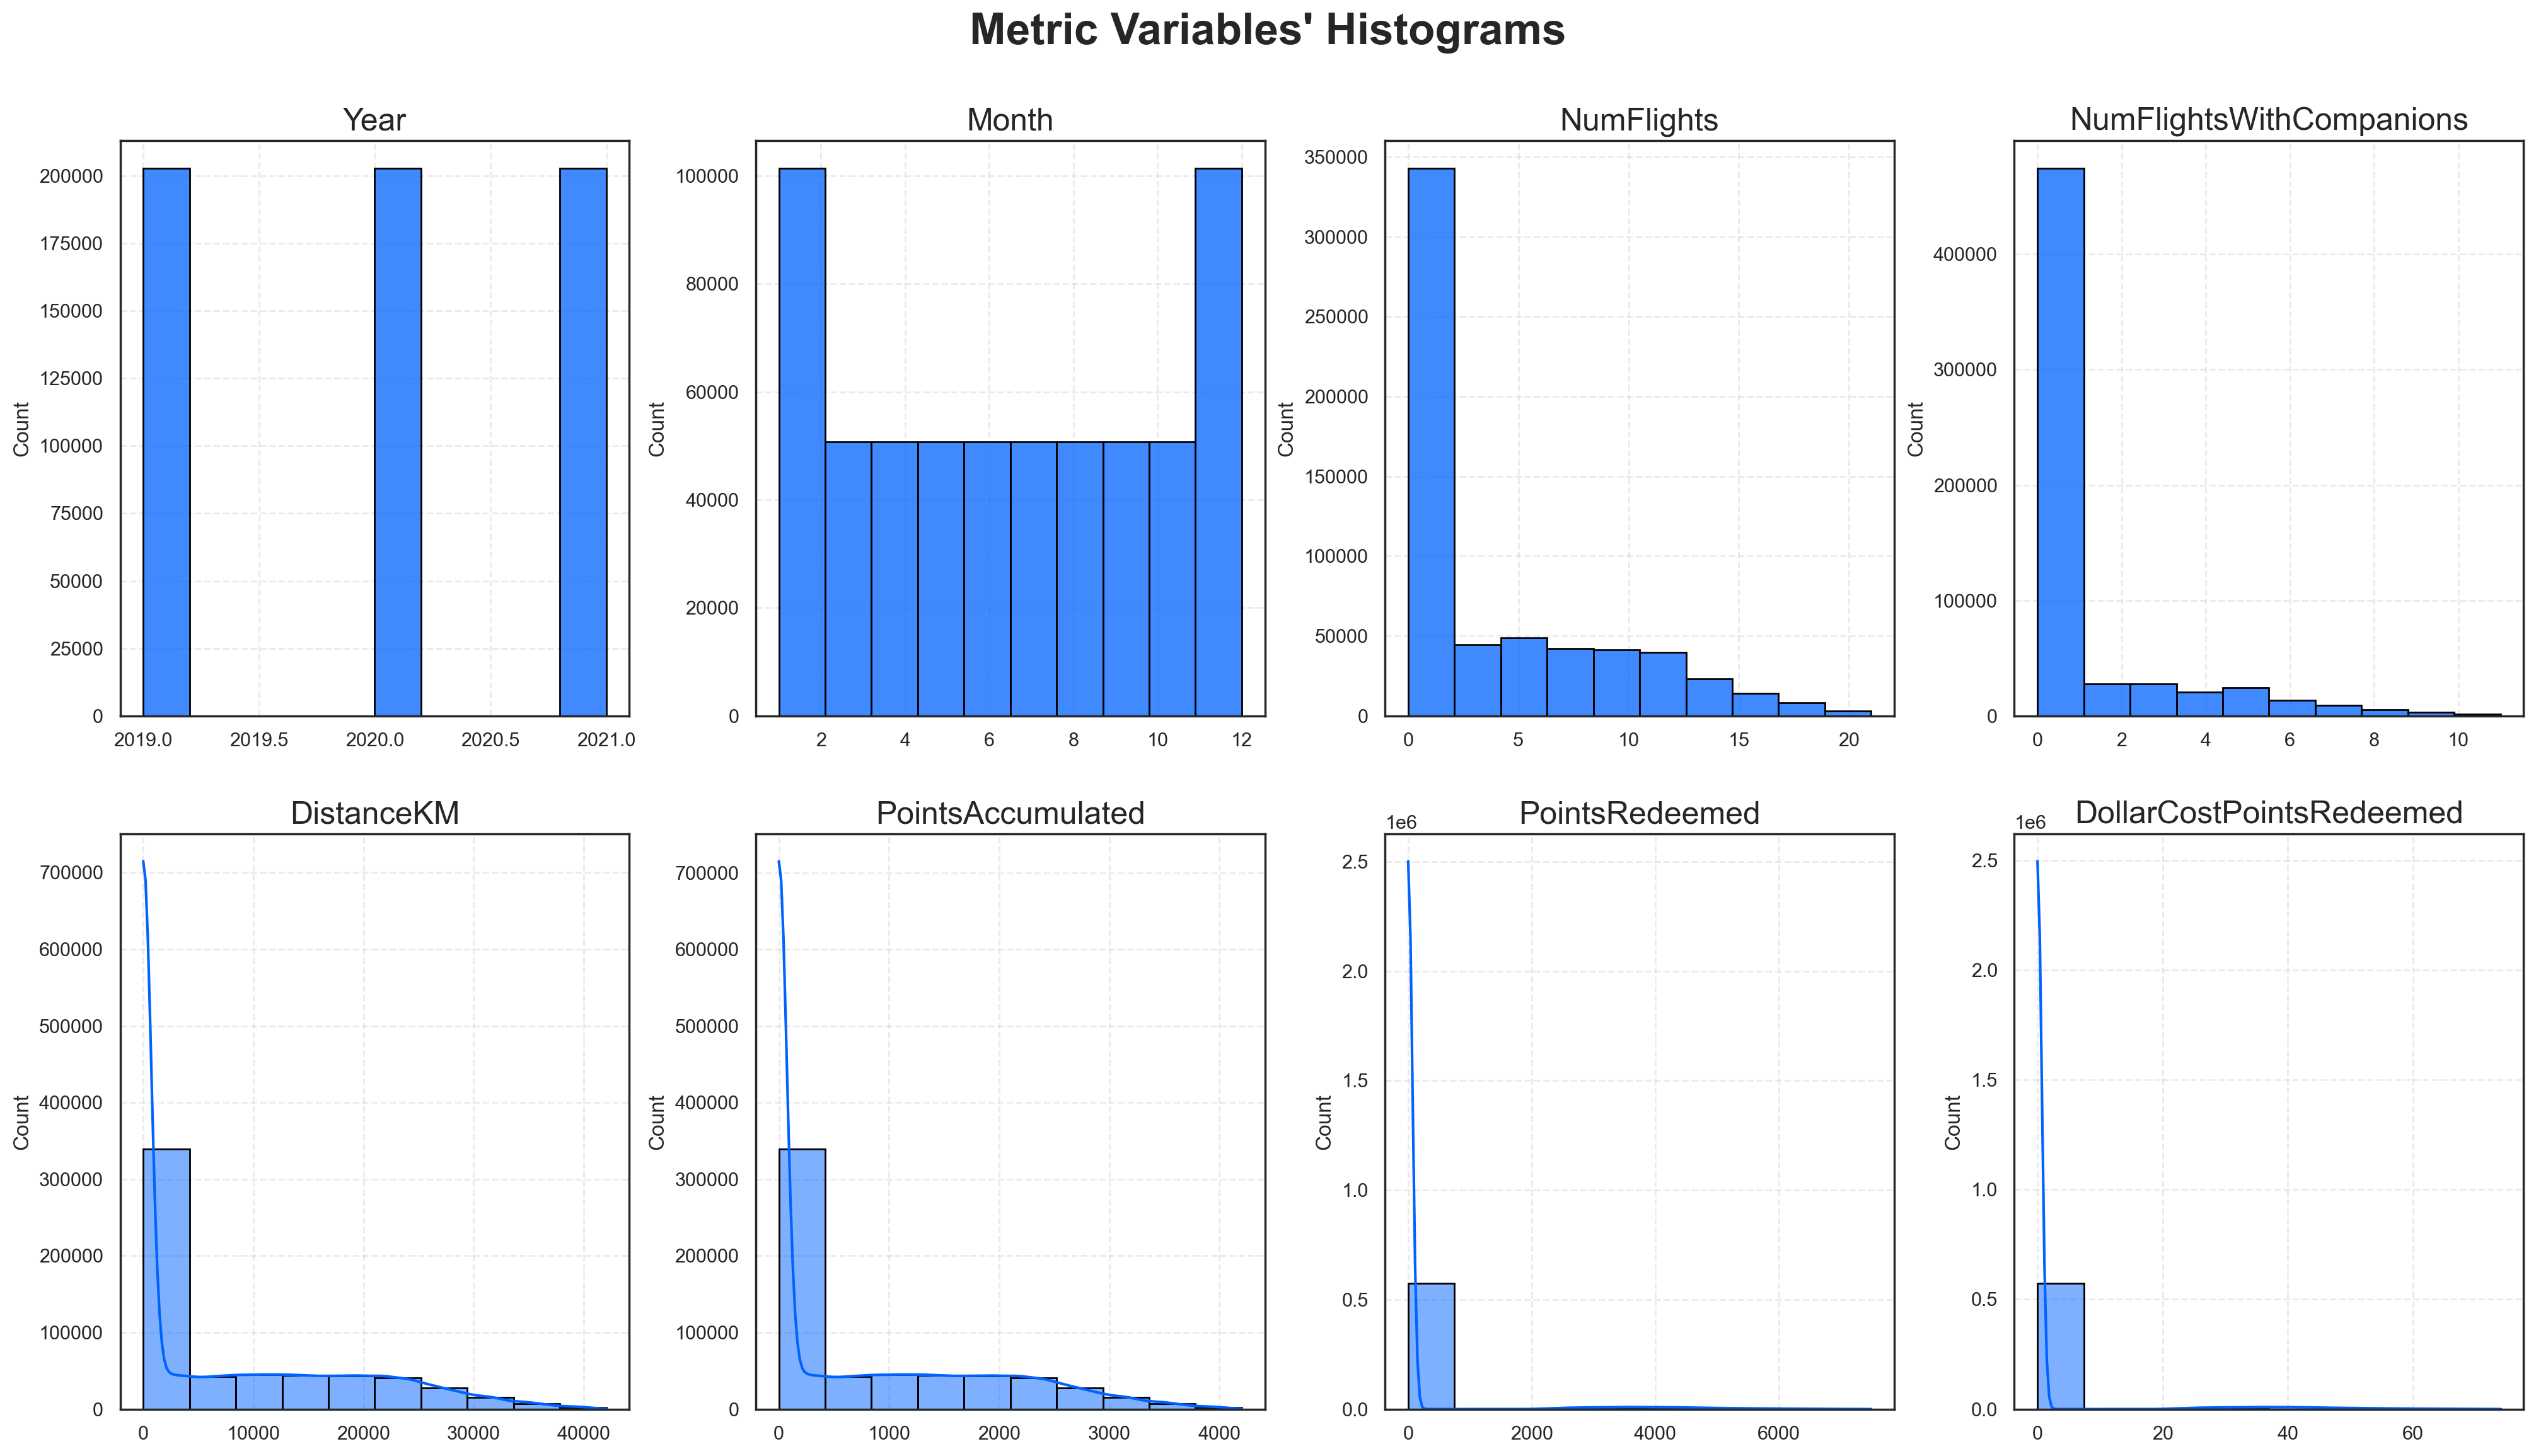

In [5]:
# Set number of rows and columns
sp_rows_FDB = 2
sp_cols_FDB = ceil(len(metric_features_FDB) / sp_rows_FDB)

# Set style
sns.set_style("white") # increase contrast

# Create figure
fig, axes = plt.subplots(sp_rows_FDB,
                         sp_cols_FDB,
                         figsize=(20, 11),
                         constrained_layout=True)

# Additional spacing between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot data
for ax, feat in zip(axes.flatten(), metric_features_FDB):
    
    sns.histplot(flightsDB[feat],
                 bins=10,
                 kde=(feat in continuous_FDB), #smooth line only for continuous variables
                 ax=ax,
                 color="#0062FF",
                 edgecolor="black")
    
    ax.set_title(feat, fontsize=18)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_xlabel("")

# Global title
plt.suptitle("Metric Variables' Histograms",
             fontsize=25,
             fontweight="bold",
             y=1.05)

# Save figure
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)
fig.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_histograms.png'),
            dpi=200)

# display output
plt.show()


From the histograms above we can see that:

- `Year:` The data is distributed only between 2019 and 2021, indicating that the set covers three years of operations. The number of records is similar between years, suggesting consistency in data collection over time.
- `Month:` he frequency of the first few months and the last ones is higher than the middle months. Also, the middle months have all the same frequency, this is the distribution is almost uniform across this months;
- `Number of Flights and Flights with Companions:` Most customers make few trips (1 to 3 flights). Few customers travel frequently—they are the outliers;
- `Distance KM:` Most flights are short-haul. There are some long-haul flights that can represent the outliers;
- `Points Accumulated:` Only a small percentage of customers accumulate many points;
- `Points Redeemed:` Almost all customers do not redeem points or redeem very few;
- `Dollar Cost Points Redeemed:` As expected, this has the same behaviour as 'Points Redeemed' because it's just the equivalent in dollars.

### Boxplots

To complement the distribution analysis provided by the histograms, we use boxplots to visually identify potential outliers and to summarize the spread and central tendency of each numerical feature. Boxplots efficiently highlight extreme values and give clear insight into the presence of skewness and variability within the data, supporting robust data quality assessment and subsequent analytical steps.

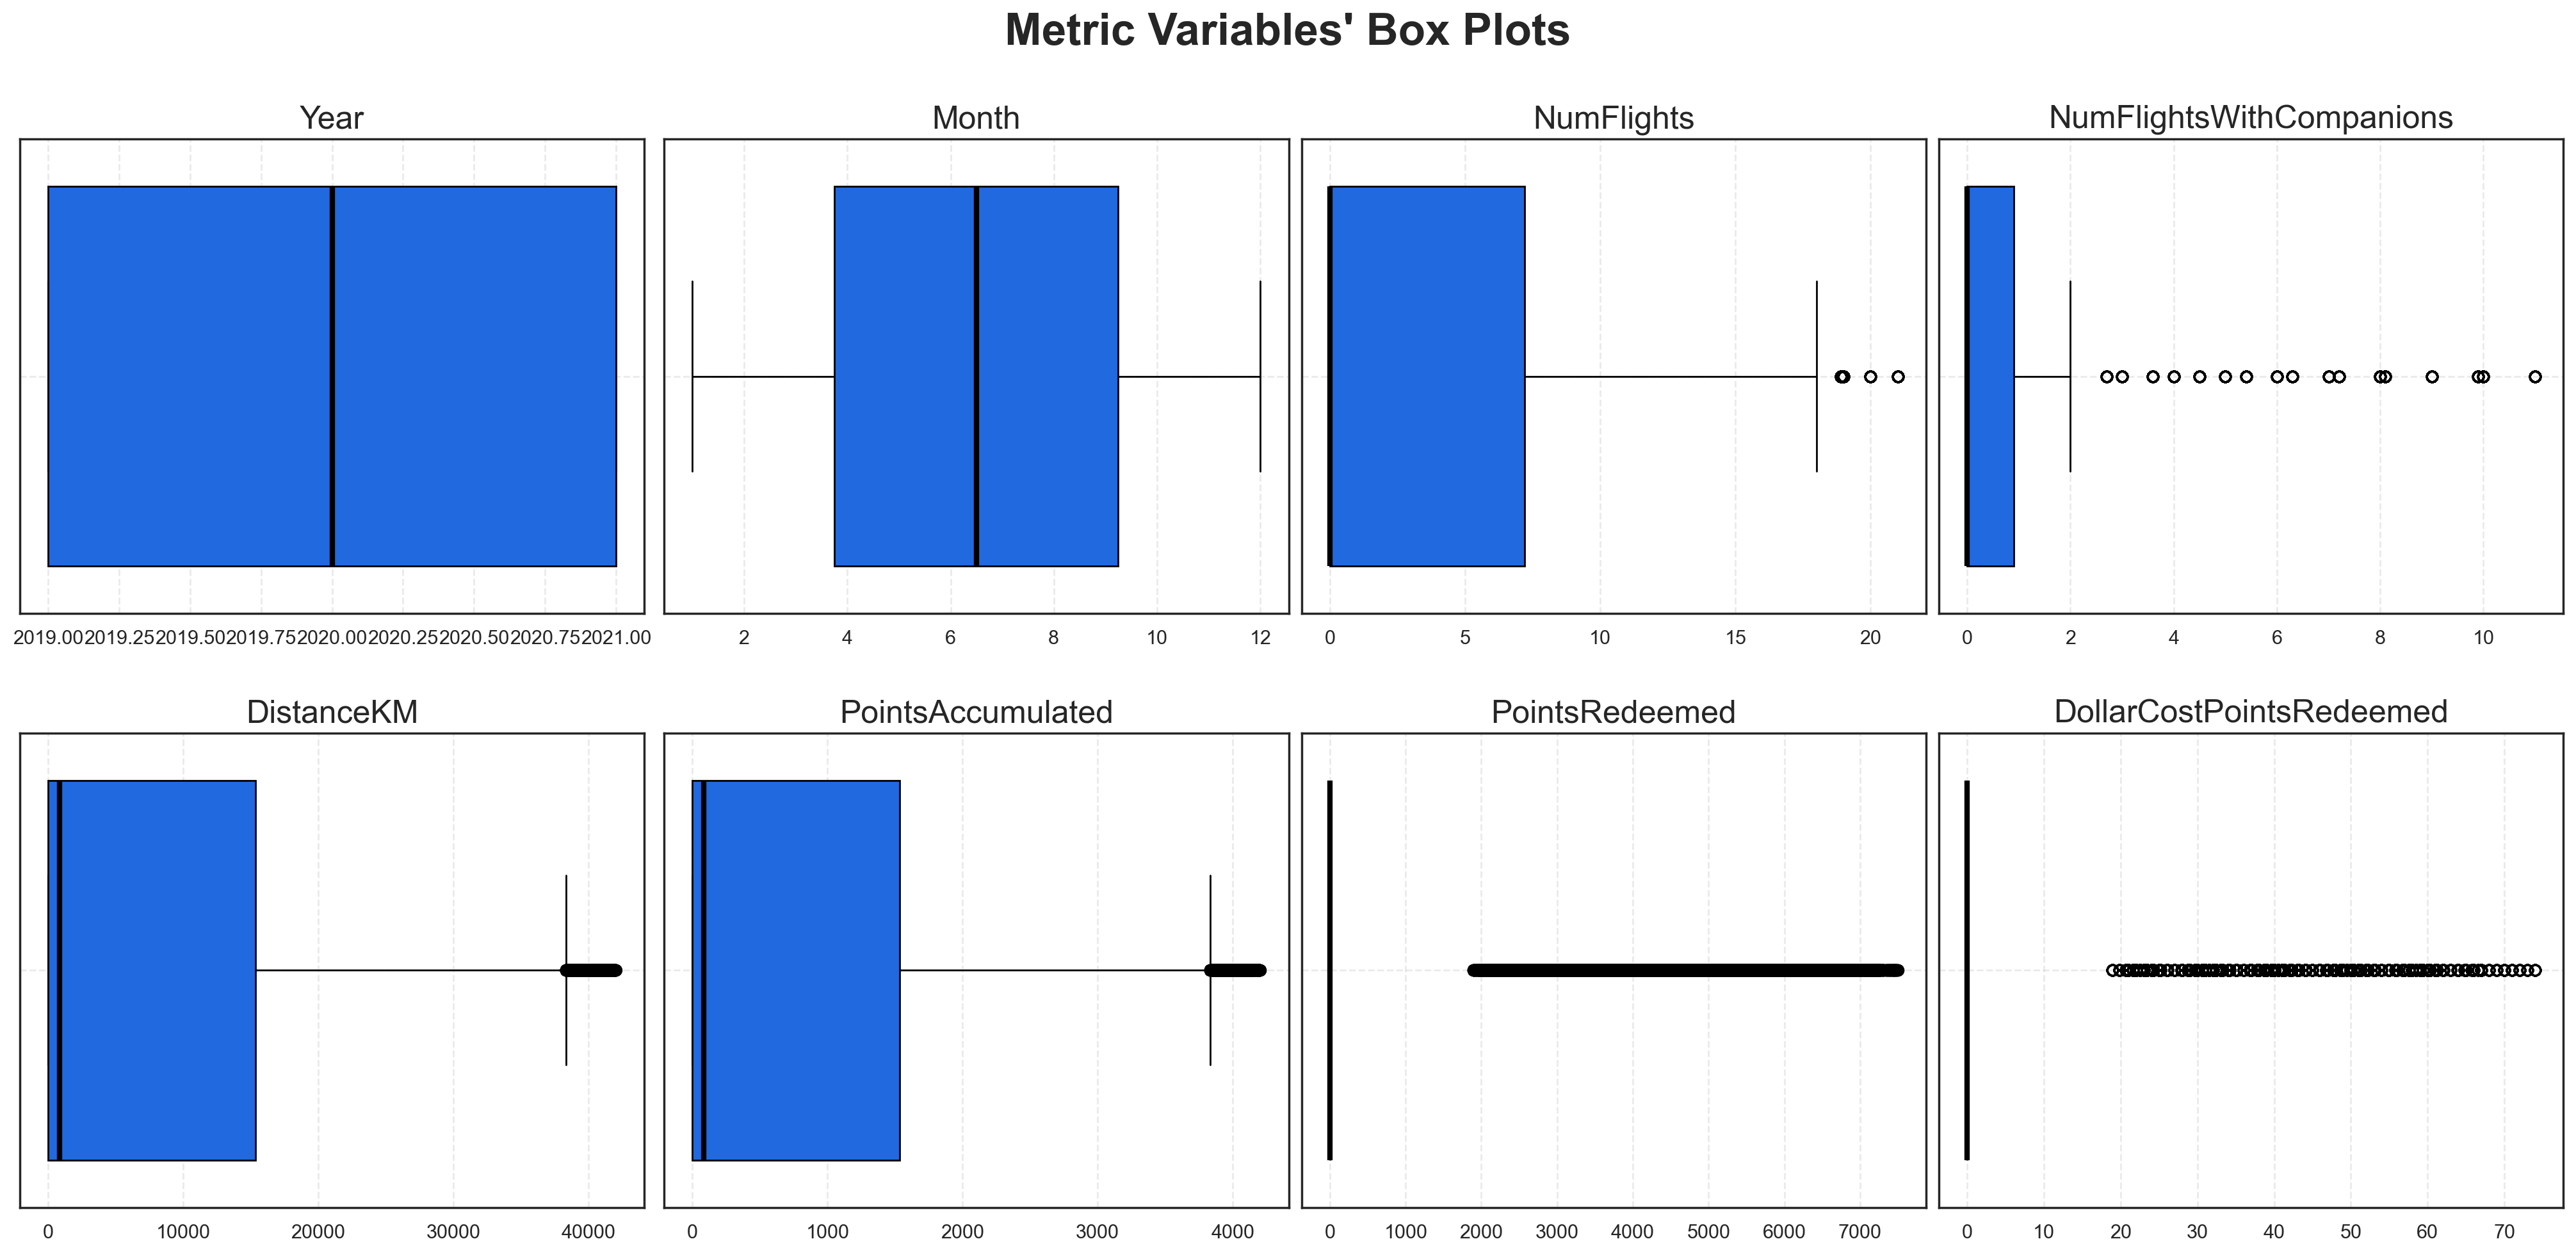

In [6]:
# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(sp_rows_FDB, 
                         sp_cols_FDB, 
                         figsize=(20, 10),
                         constrained_layout=True) # Adjust automatically spacing between subplot and labels 

# Increase vertical space between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features_FDB): 
    sns.boxplot(x=flightsDB[feat], ax=ax,
                # Set inside color to blue
                color="#0062FF",
                # Set line colors to black
                boxprops=dict(edgecolor="black"),
                whiskerprops=dict(color="black"),
                capprops=dict(color="black"),
                medianprops=dict(color="black", linewidth=3),
                flierprops=dict(markeredgecolor="black"))
    
    # Put grid with low opacity and dashed line so it's visible, but not distracting
    ax.grid(True, linestyle="--", alpha=0.4)

    # Put title of each graph with bigger font
    ax.set_title(feat, fontsize=18)

    # Hide x label since we already have the boxlplot title at the top
    ax.set_xlabel("")
    
# Layout
# Add title and make it bigger
plt.suptitle("Metric Variables' Box Plots", 
             fontsize = 25, fontweight="bold")

# Create the folder '../figures/eda' if it doesn't already exist
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)

# Save figure to a png file in the folder created before
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_boxplots.png'), dpi=200)

# Show plot
plt.show()

From the boxplots above we can conclude that:

- `Year:` The values are evenly distributed between 2019 and 2021, with no outliers;
- `Month:` The distribution is almost uniform, with slight asymmetry (probably more records in the first and last few months).
- `Number of Flights:` Low median and strong skew to the right (positive asymmetry). Many outliers above ~15 flights — few customers travel frequently;
- `Number of Flights with Companions:` Median close to 0 and some outliers that represent the clients that travel in big groups;
- `Distance KM:` large number of short flights and a few very long ones that greatly influence the average;
- `Points Accumulated:` Very low median and a lot of outliers. This means that only a few customers accumulate large volumes of points;
-`Points Redeemed:` The same as before, a very big majority of values are low with a big number of outliers;
- `Dollar Cost Points Redeemed:` A very similar distribution to 'Points Redeemed' as expected, with the majority of values being close to 0 and many outliers.

## Relationship between metric features

### DistanceKM and PointsAccumulated

Through a scatter plot, we want to find if there is a relationship between these 2 variables (DistanceKM and PointsAccumulated), which essentially means we want to find out if the PointsAccumulated are attributed to the customers based on the distance they travel per month with AIAI.

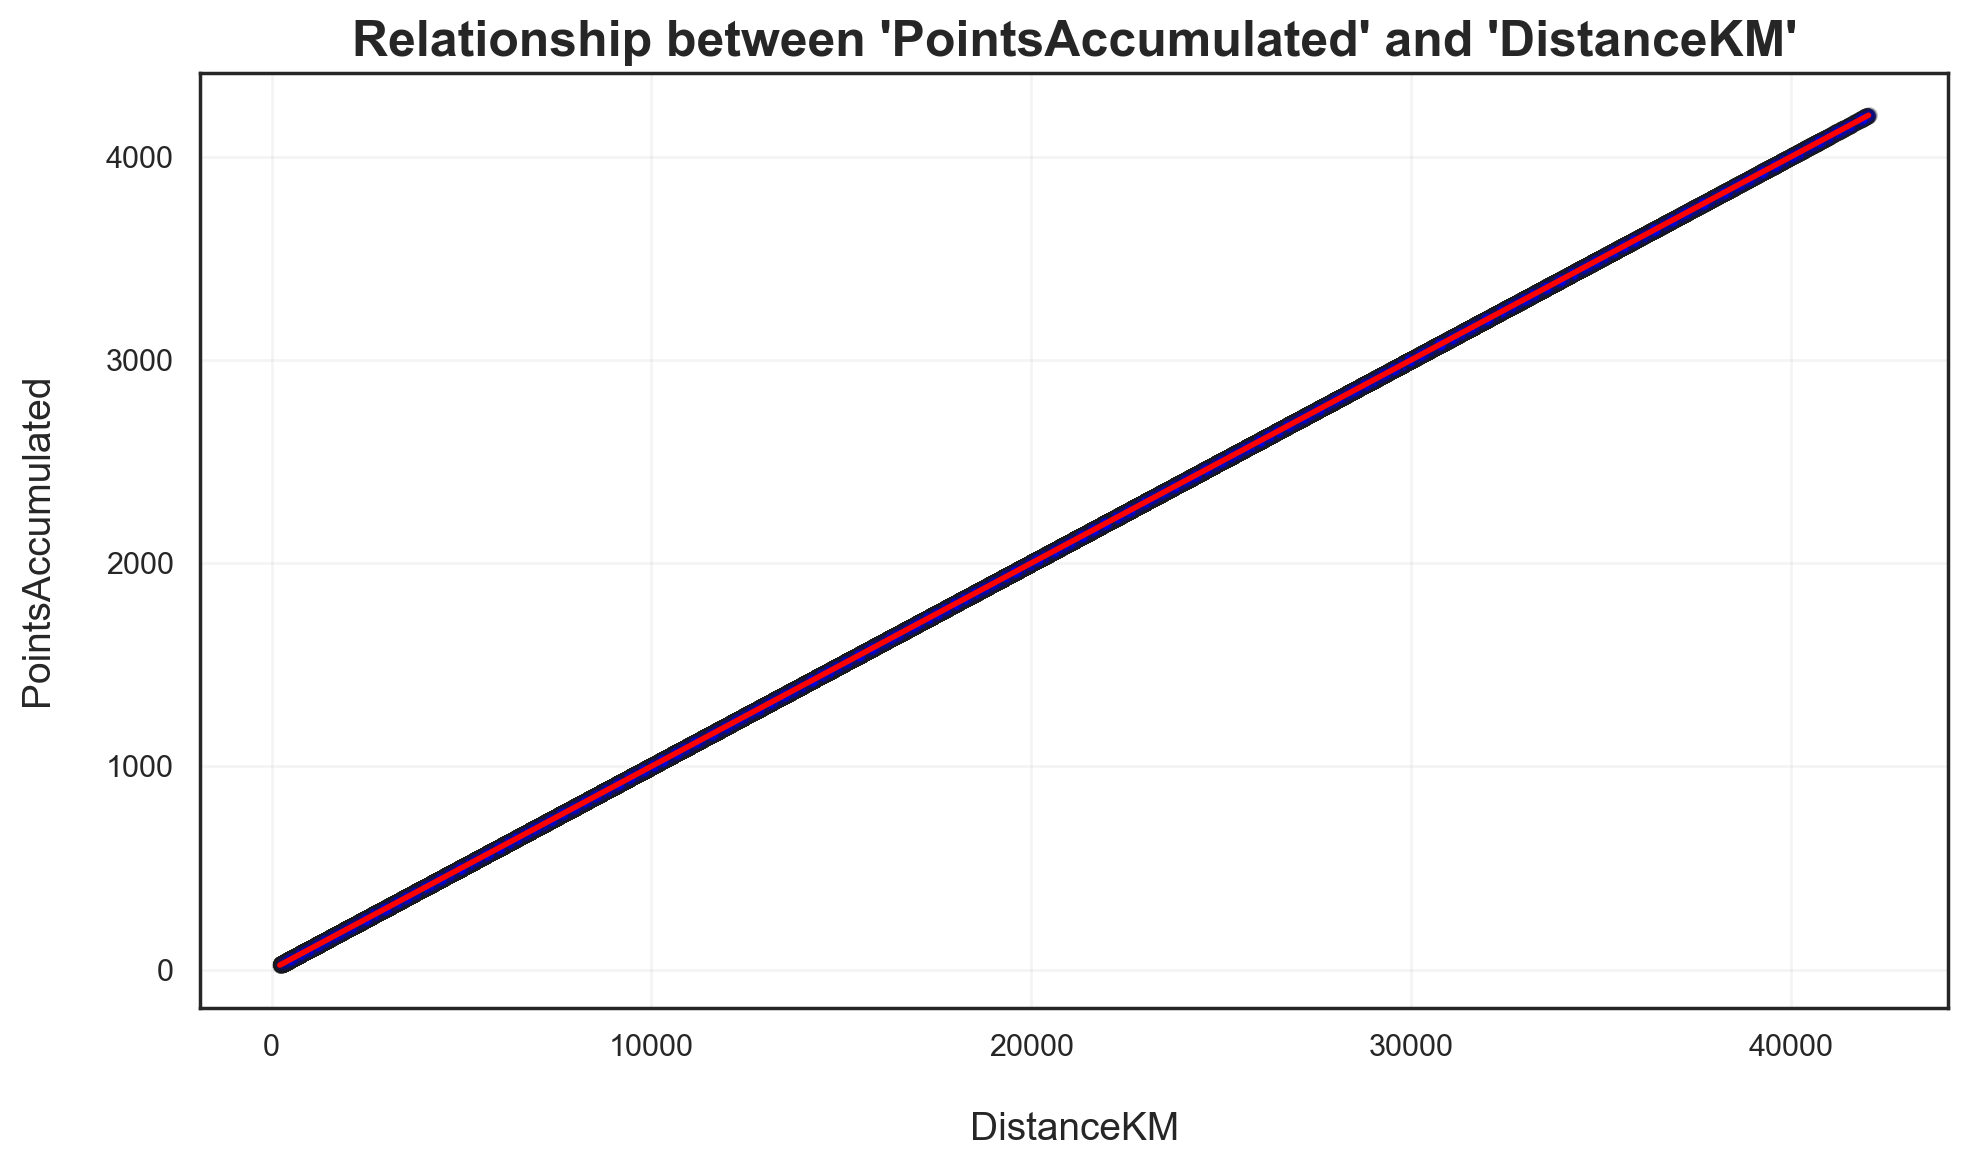

In [7]:
mask = ((flightsDB["DistanceKM"] > 0) &
        (flightsDB["PointsAccumulated"] > 0))

distance_clean = flightsDB.loc[mask, "DistanceKM"]
points_acc = flightsDB.loc[mask, "PointsAccumulated"]

# Scatter plot as before
plt.figure(figsize=(10, 6))
sns.set_style("white")
plt.scatter(distance_clean, points_acc, s=25, alpha=0.3, c='blue', edgecolor='k')

# Fit a linear trend line
coeffs = np.polyfit(distance_clean, points_acc, 1)
trend = np.poly1d(coeffs)
x = np.linspace(distance_clean.min(), distance_clean.max(), 100)
plt.plot(x, trend(x), color='red', linewidth=2)  # Line

plt.title("Relationship between 'PointsAccumulated' and 'DistanceKM'", fontsize=18, fontweight='bold')
plt.xlabel("DistanceKM", fontsize=14, labelpad=18)
plt.ylabel("PointsAccumulated", fontsize=14, labelpad=18)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


The scatter plot demonstrates a linear relationship between 'PointsAccumulated' and 'DistanceKM'. This indicates that the points awarded are a direct function of the flight distance, following a consistent rule. Consequently, these two variables are highly collinear and describe essentially the same information in this context.

### Points Redeemed and Dollar Cost Points Redeemed

To evaluate the relationship between 'PointsRedeemed' and 'DollarCostPointsRedeemed', we use a scatter plot. Given that 'DollarCostPointsRedeemed' is the monetary equivalent of the points redeemed, we expect to observe a strong linear correlation between these two variables.

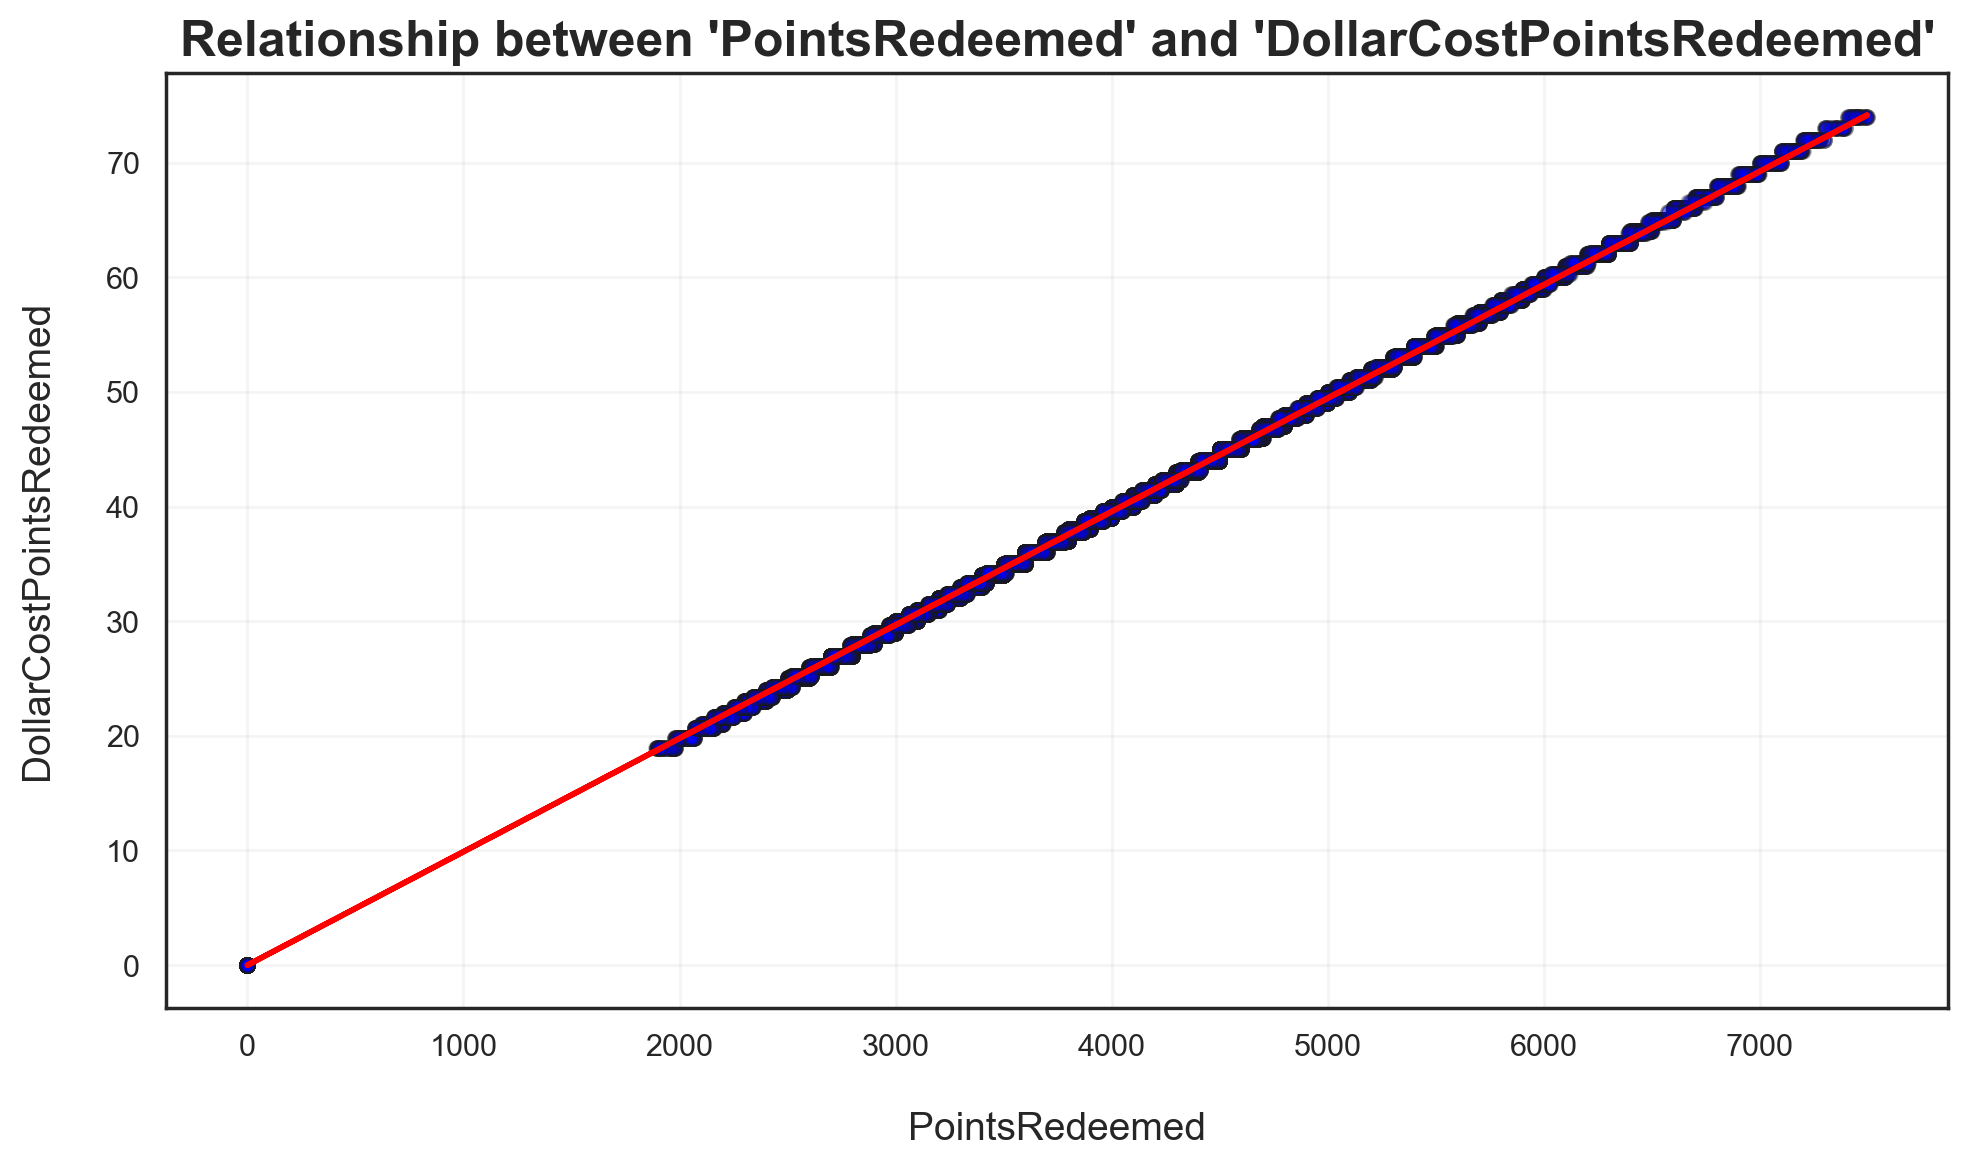

In [8]:
x = flightsDB["PointsRedeemed"]
y = flightsDB["DollarCostPointsRedeemed"]

# Scatter plot as before
plt.figure(figsize=(10, 6))
sns.set_style("white")
plt.scatter(x, y, s=25, alpha=0.3, c='blue', edgecolor='k')

# Fit a linear trend line
coeffs = np.polyfit(x, y, 1)
trend = np.poly1d(coeffs)
plt.plot(x, trend(x), color='red', linewidth=2)  # Line

plt.title("Relationship between 'PointsRedeemed' and 'DollarCostPointsRedeemed'", fontsize=18, fontweight='bold')
plt.xlabel("PointsRedeemed", fontsize=14, labelpad=18)
plt.ylabel("DollarCostPointsRedeemed", fontsize=14, labelpad=18)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


As expected, the scatter plot shows a perfect correlation between the two variables, which demonstrates that 'DollarCostPointsRedeemed' is simply the monetary equivalent of 'PointsRedeemed'. Therefore, either variable can be used for analysis.

## Categorical features visualizations (FlightsDB)

### Bar Plot

To better understand the distribution of our categorical variable, we visualize it using a bar plot. 

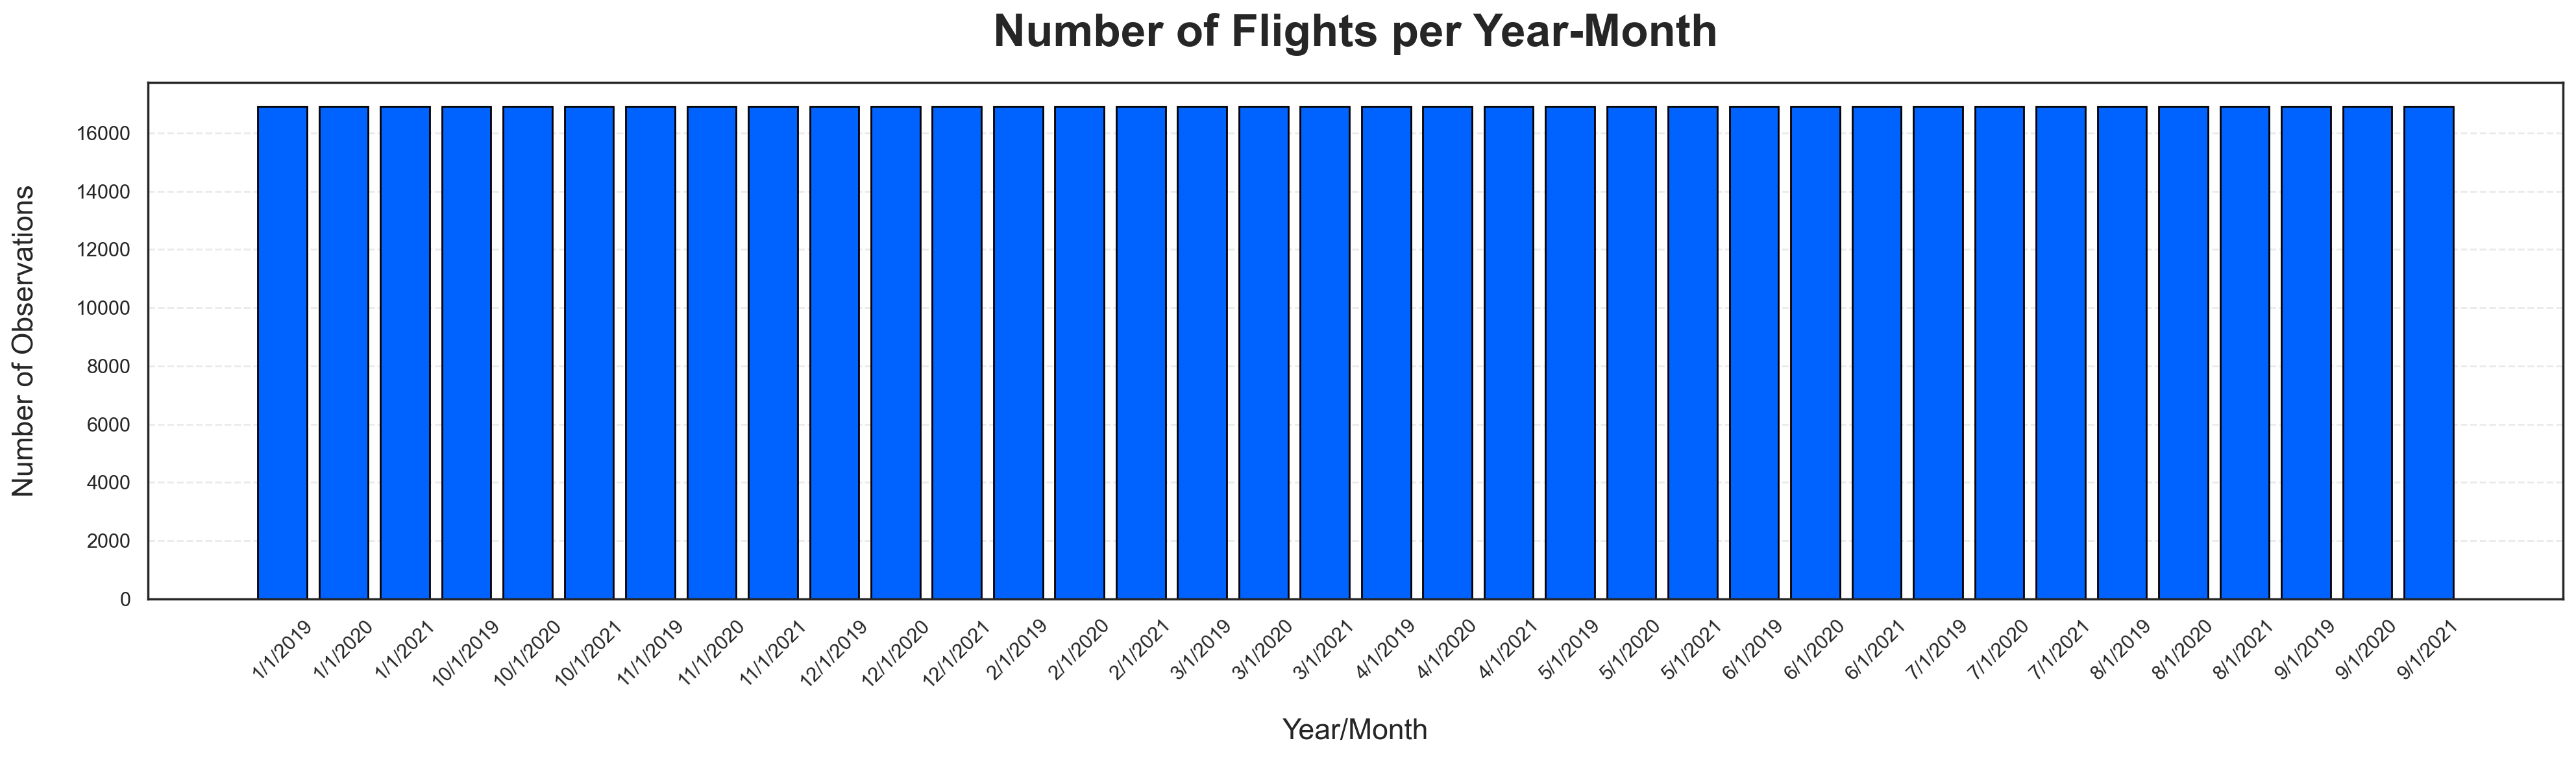

In [10]:
time_counts = flightsDB['YearMonthDate'].value_counts().sort_index()

plt.figure(figsize=(20,6))
bars = plt.bar(time_counts.index, time_counts.values, color="#0062FF", edgecolor="black")

plt.title("Number of Flights per Year-Month", fontsize=25, fontweight="bold", pad=20)
plt.xlabel("Year/Month", fontsize=16, labelpad=15)
plt.ylabel("Number of Observations", fontsize=16, labelpad=20)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.4, axis="y")
plt.tight_layout()
plt.show()

The bar chart referring to the YearMonthTime variable does not provide relevant information for the analysis, since each month/year value is unique or has the same number of records. Therefore, no meaningful conclusions can be drawn from this visualization. However, it confirms a conclusion previously identified: the data is consistent across all months within the three years covered, with no missing entries. Thus, to obtain more relevant information, we will relate the categorical variable "YearMonthDate" with the numerical variable "NumFlights".

### NumFlights (numerical) e YearMonthDate (categorical)

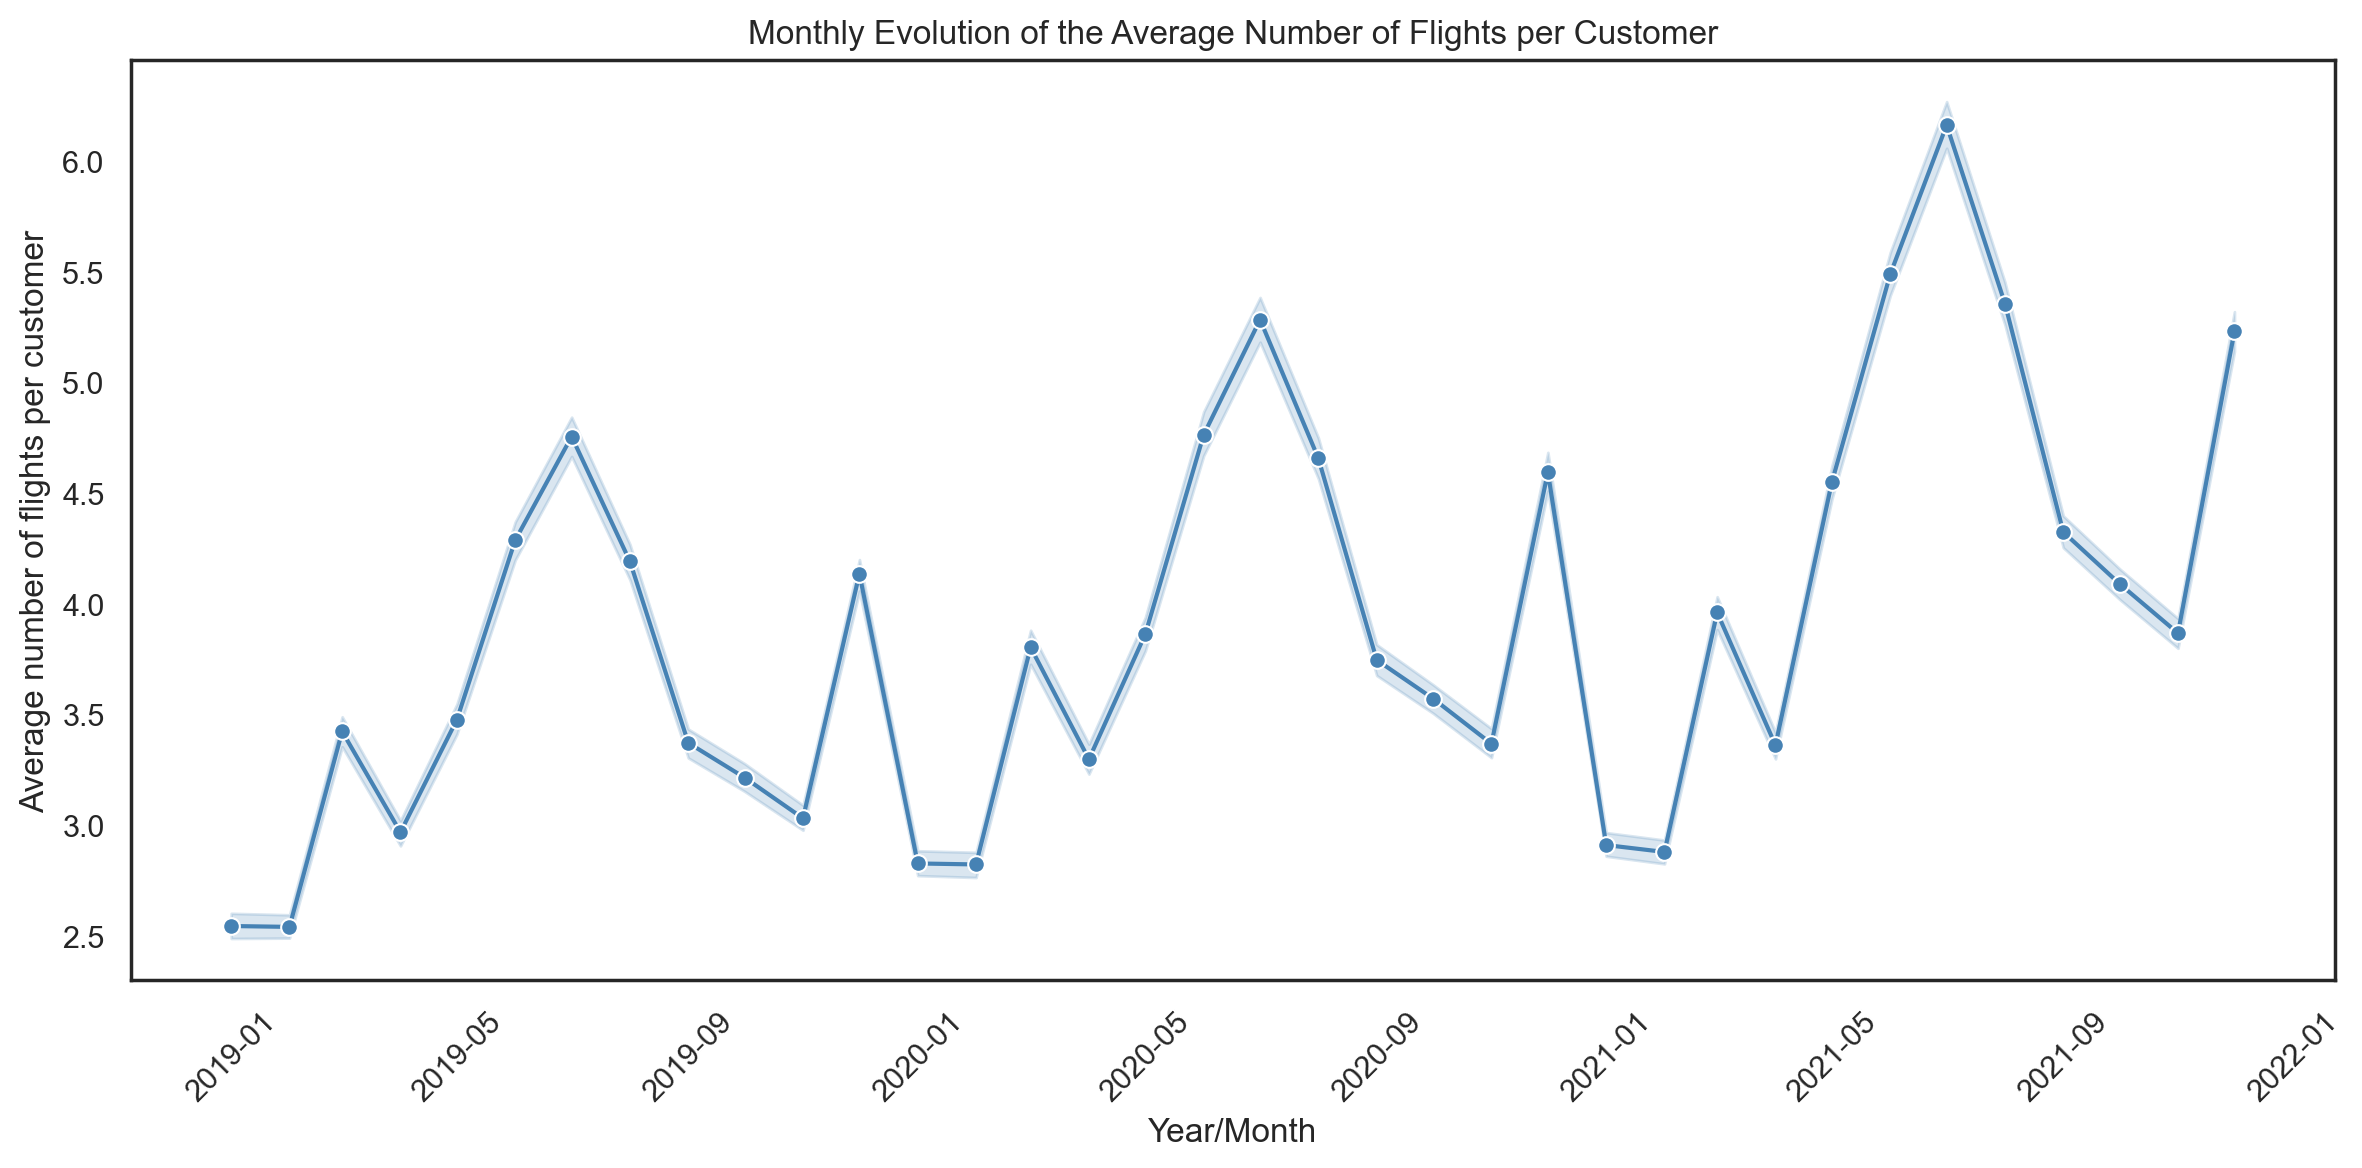

In [14]:
flightsDB["YearMonthDate"] = pd.to_datetime(flightsDB["YearMonthDate"])

# Ordenar pelas datas
flightsDB = flightsDB.sort_values("YearMonthDate")

plt.figure(figsize=(12,6))
sns.lineplot(
    x="YearMonthDate",
    y="NumFlights",
    data=flightsDB,
    marker="o",
    color="steelblue"
)

plt.title("Monthly Evolution of the Average Number of Flights per Customer")
plt.xlabel("Year/Month")
plt.ylabel("Average number of flights per customer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph shows the monthly evolution of the average number of flights per customer between 2019 and 2021.
A significant seasonal variation can be observed, with peaks of activity in certain months—possibly associated with holiday seasons, festive periods, or promotional campaigns—and decreases in the following months.
The sharp decline at the beginning of 2020 coincides with the impact of the COVID-19 pandemic, which led to a strong reduction in air travel.
From 2021 onwards, a gradual recovery can be seen, reflecting the progressive return of customers to traveling.

# Descriptive Statistics and Visualisations (CustomerDB)

Now, on the customerDB dataset, we create two lists to distinguish between metric and non-metric features. This separation helps us to analyze each group appropriately and ensures that our statistical and visual analyses are focused on the most relevant characteristics of customer behavior.

In [ ]:
metric_features_CDB = customerDB.select_dtypes(include=['number']).columns.tolist()
continuous_CDB = ["Latitude", "Longitude", "Income", "Customer Lifetime Value"]
non_metric_features_CDB = customerDB.columns.drop(metric_features_CDB).to_list()

print("Metric Features:")
for i, feature in enumerate(metric_features_CDB, 1):
    print(f" {i}. {feature}")

print("\nNon-Metric Features:")
for i, feature in enumerate(non_metric_features_CDB, 1):
    print(f" {i}. {feature}")

Metric Features:
 1. Latitude
 2. Longitude
 3. Income
 4. Customer Lifetime Value

Non-Metric Features:
 1. First Name
 2. Last Name
 3. Customer Name
 4. Country
 5. Province or State
 6. City
 7. Postal code
 8. Gender
 9. Education
 10. Location Code
 11. Marital Status
 12. LoyaltyStatus
 13. EnrollmentDateOpening
 14. CancellationDate
 15. EnrollmentType


### Histograms

After distinguishing between metric and non-metric features, we observe that all metric variables in the customerDB dataset are continuous. To explore their distributions, we present histograms for each variable. For a clearer representation, and to better visualize the underlying patterns, we overlay a smooth line on each histogram. This general analysis helps to identify trends and understand the overall behavior of these continuous features.

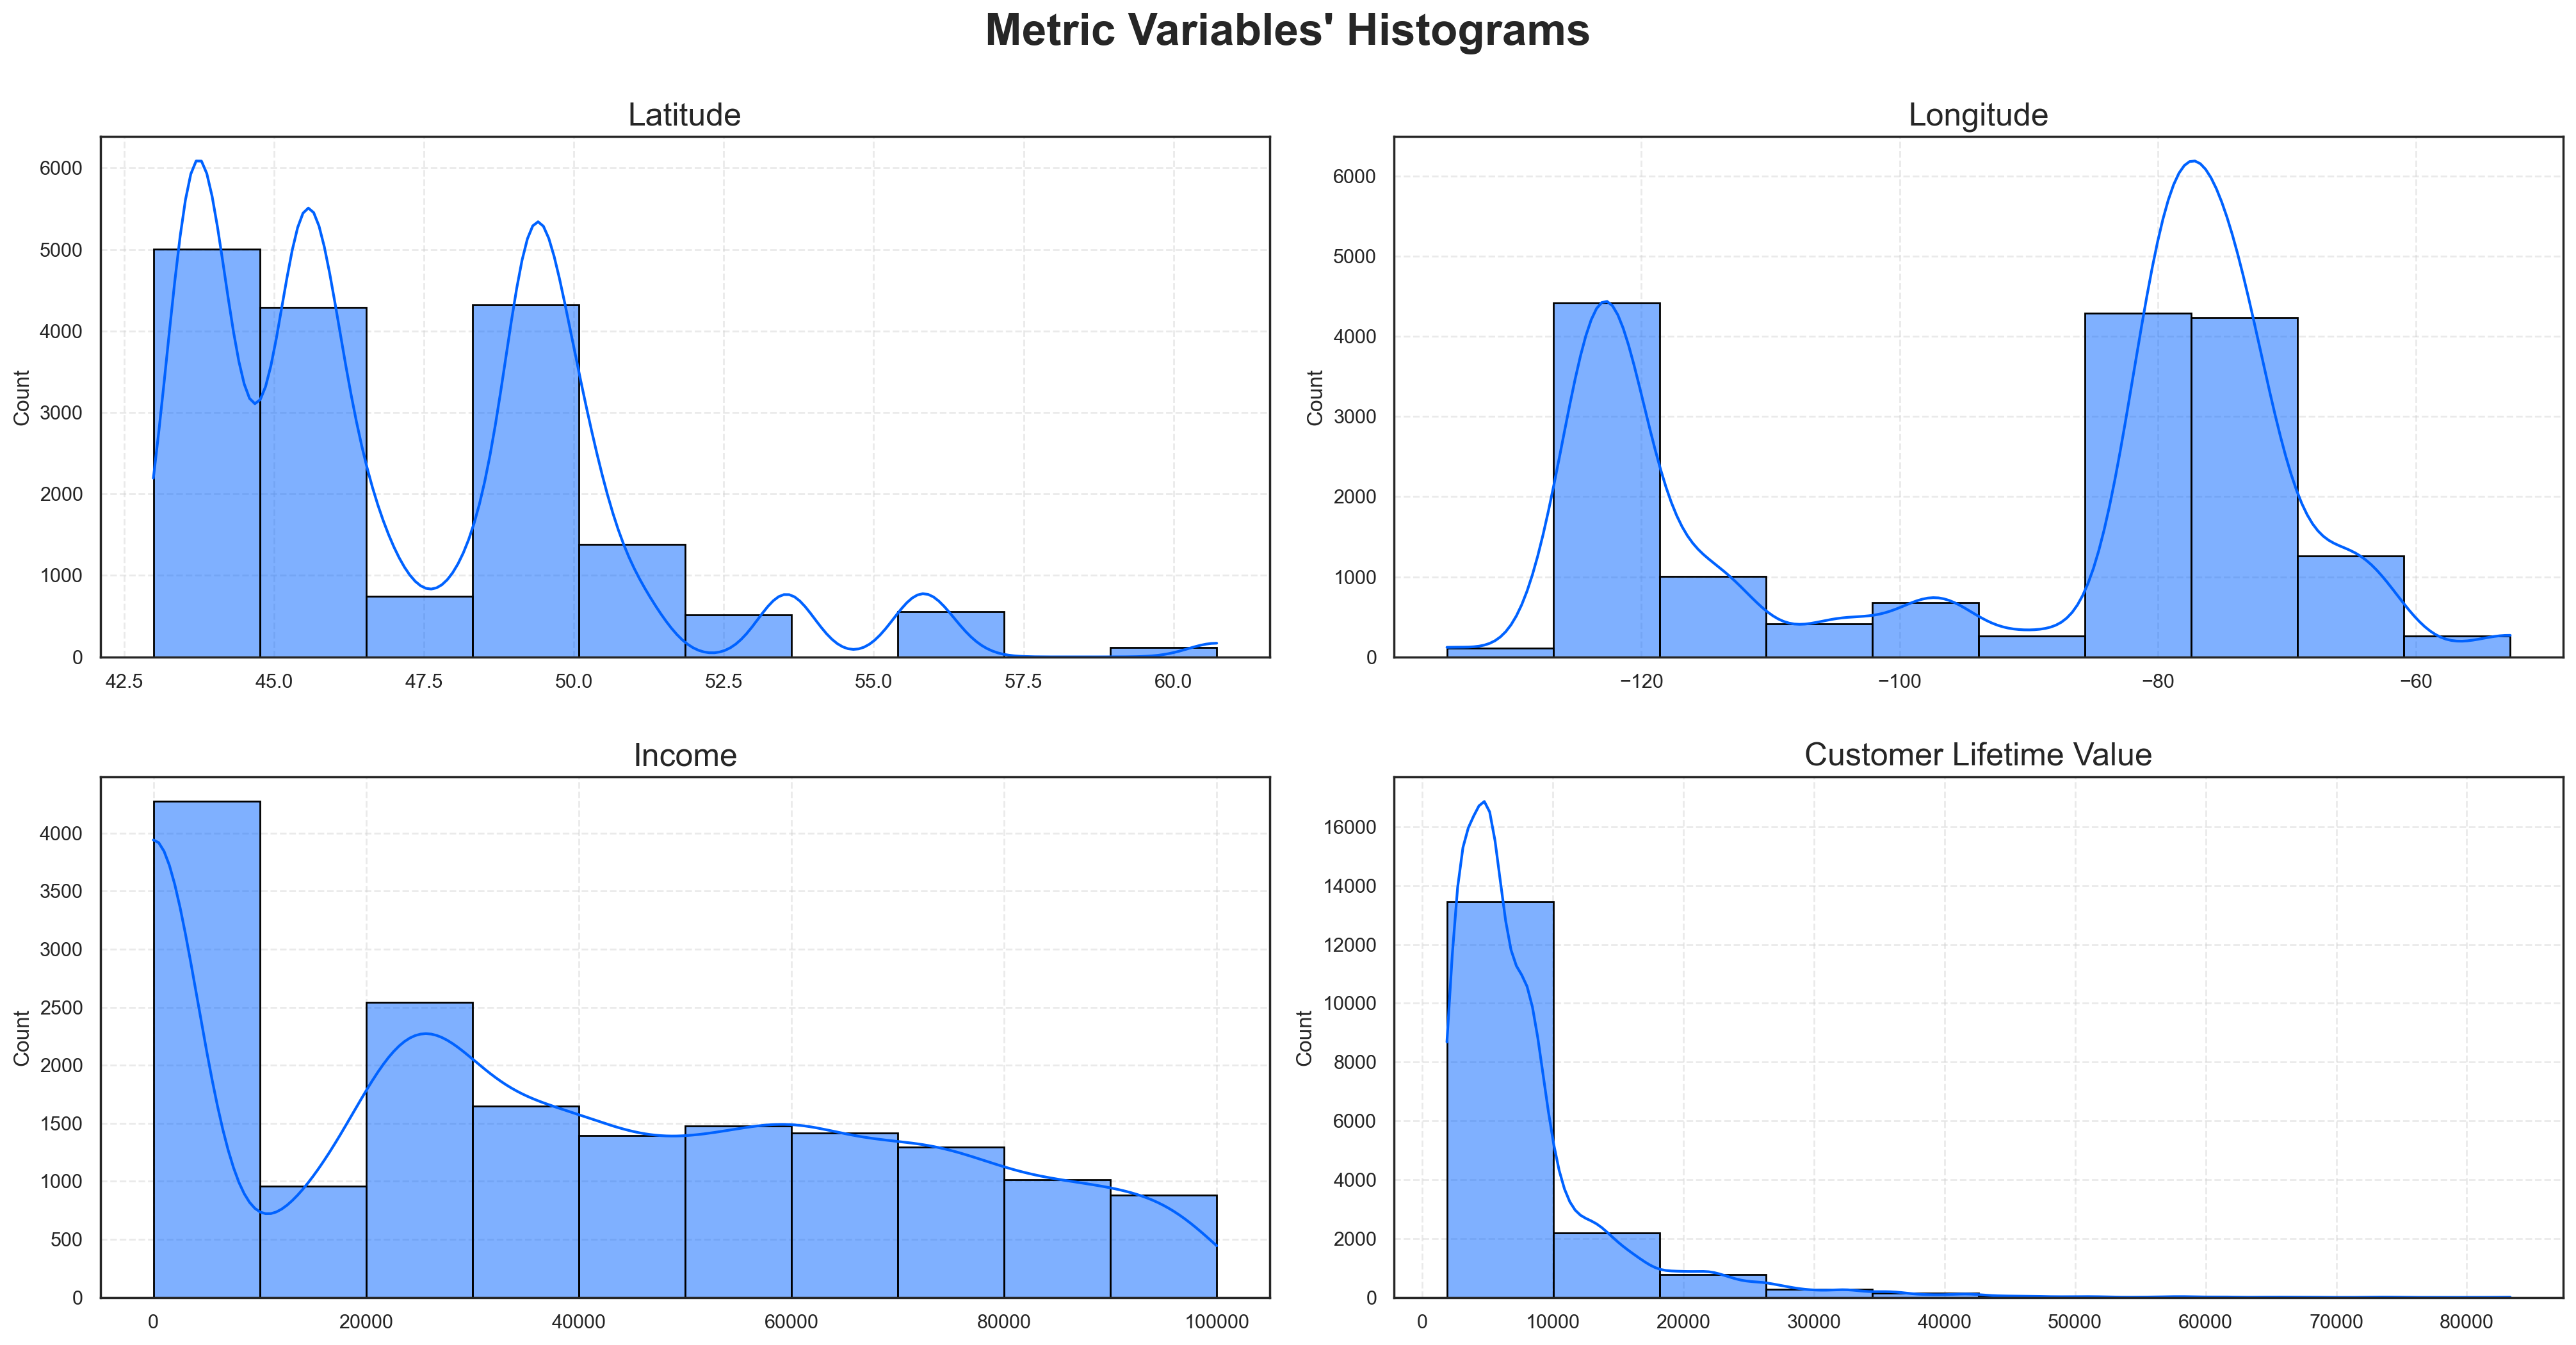

In [ ]:
# Set number of rows and columns
sp_rows_CDB = 2
sp_cols_CDB = ceil(len(metric_features_CDB) / sp_rows_CDB) # adapt the number of columns to the number of features

# Set minimal style
sns.set_style("white") # increase contrast

# Create a canvas for the metric features
fig, axes = plt.subplots(sp_rows_CDB, 
                         sp_cols_CDB, 
                         figsize=(20, 10),
                         constrained_layout=True) # Adjust automatically spacing between subplot and labels 

# Increase vertical space between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot the data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features_CDB):
    sns.histplot(customerDB[feat],
                 bins=10,
                 kde=(feat in continuous_CDB), #smooth line only for continuous variables
                 ax=ax,
                 color="#0062FF",
                 edgecolor="black")
    ax.set_title(feat, fontsize=18)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.set_xlabel("")

# Layout
# Add title, make it bigger and bold and add space between title and first row of plots
plt.suptitle("Metric Variables' Histograms", 
             fontsize = 25, fontweight="bold", y=1.05)

# Create the folder '../figures/eda' if it doesn't already exist
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)
    
# Save figure to a png file in the folder created before
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_histograms.png'), dpi=200)

# Show plot
plt.show()

From the histograms above we can see that:

- `Latitude:`Latitude shows a right skewed distribution, with very inconsistent values.

- `Longitude:` There is a concentration of values on the extremes.

- `Income`: The distribution is right-skewed with a heavy tail, biggest group being the first bin (least income), which represents low-budget travelers and it shows a sudden drop in the second bin, which could represent different customer segments (economy-class).

- `Customer Lifetime Value`: Very right-skewed distribution, with a very heavy tail, which shows the CLV sits betweeen 0 and 10.000$ for most customers.

### Boxplots

To further analyze the distribution of metric variables in the customerDB, we utilize boxplots. These visualizations allow us to efficiently spot potential outliers and to summarize key aspects such as the spread, central tendency, and skewness of each feature. This approach supports a thorough assessment of data quality and guides subsequent analytical decisions.

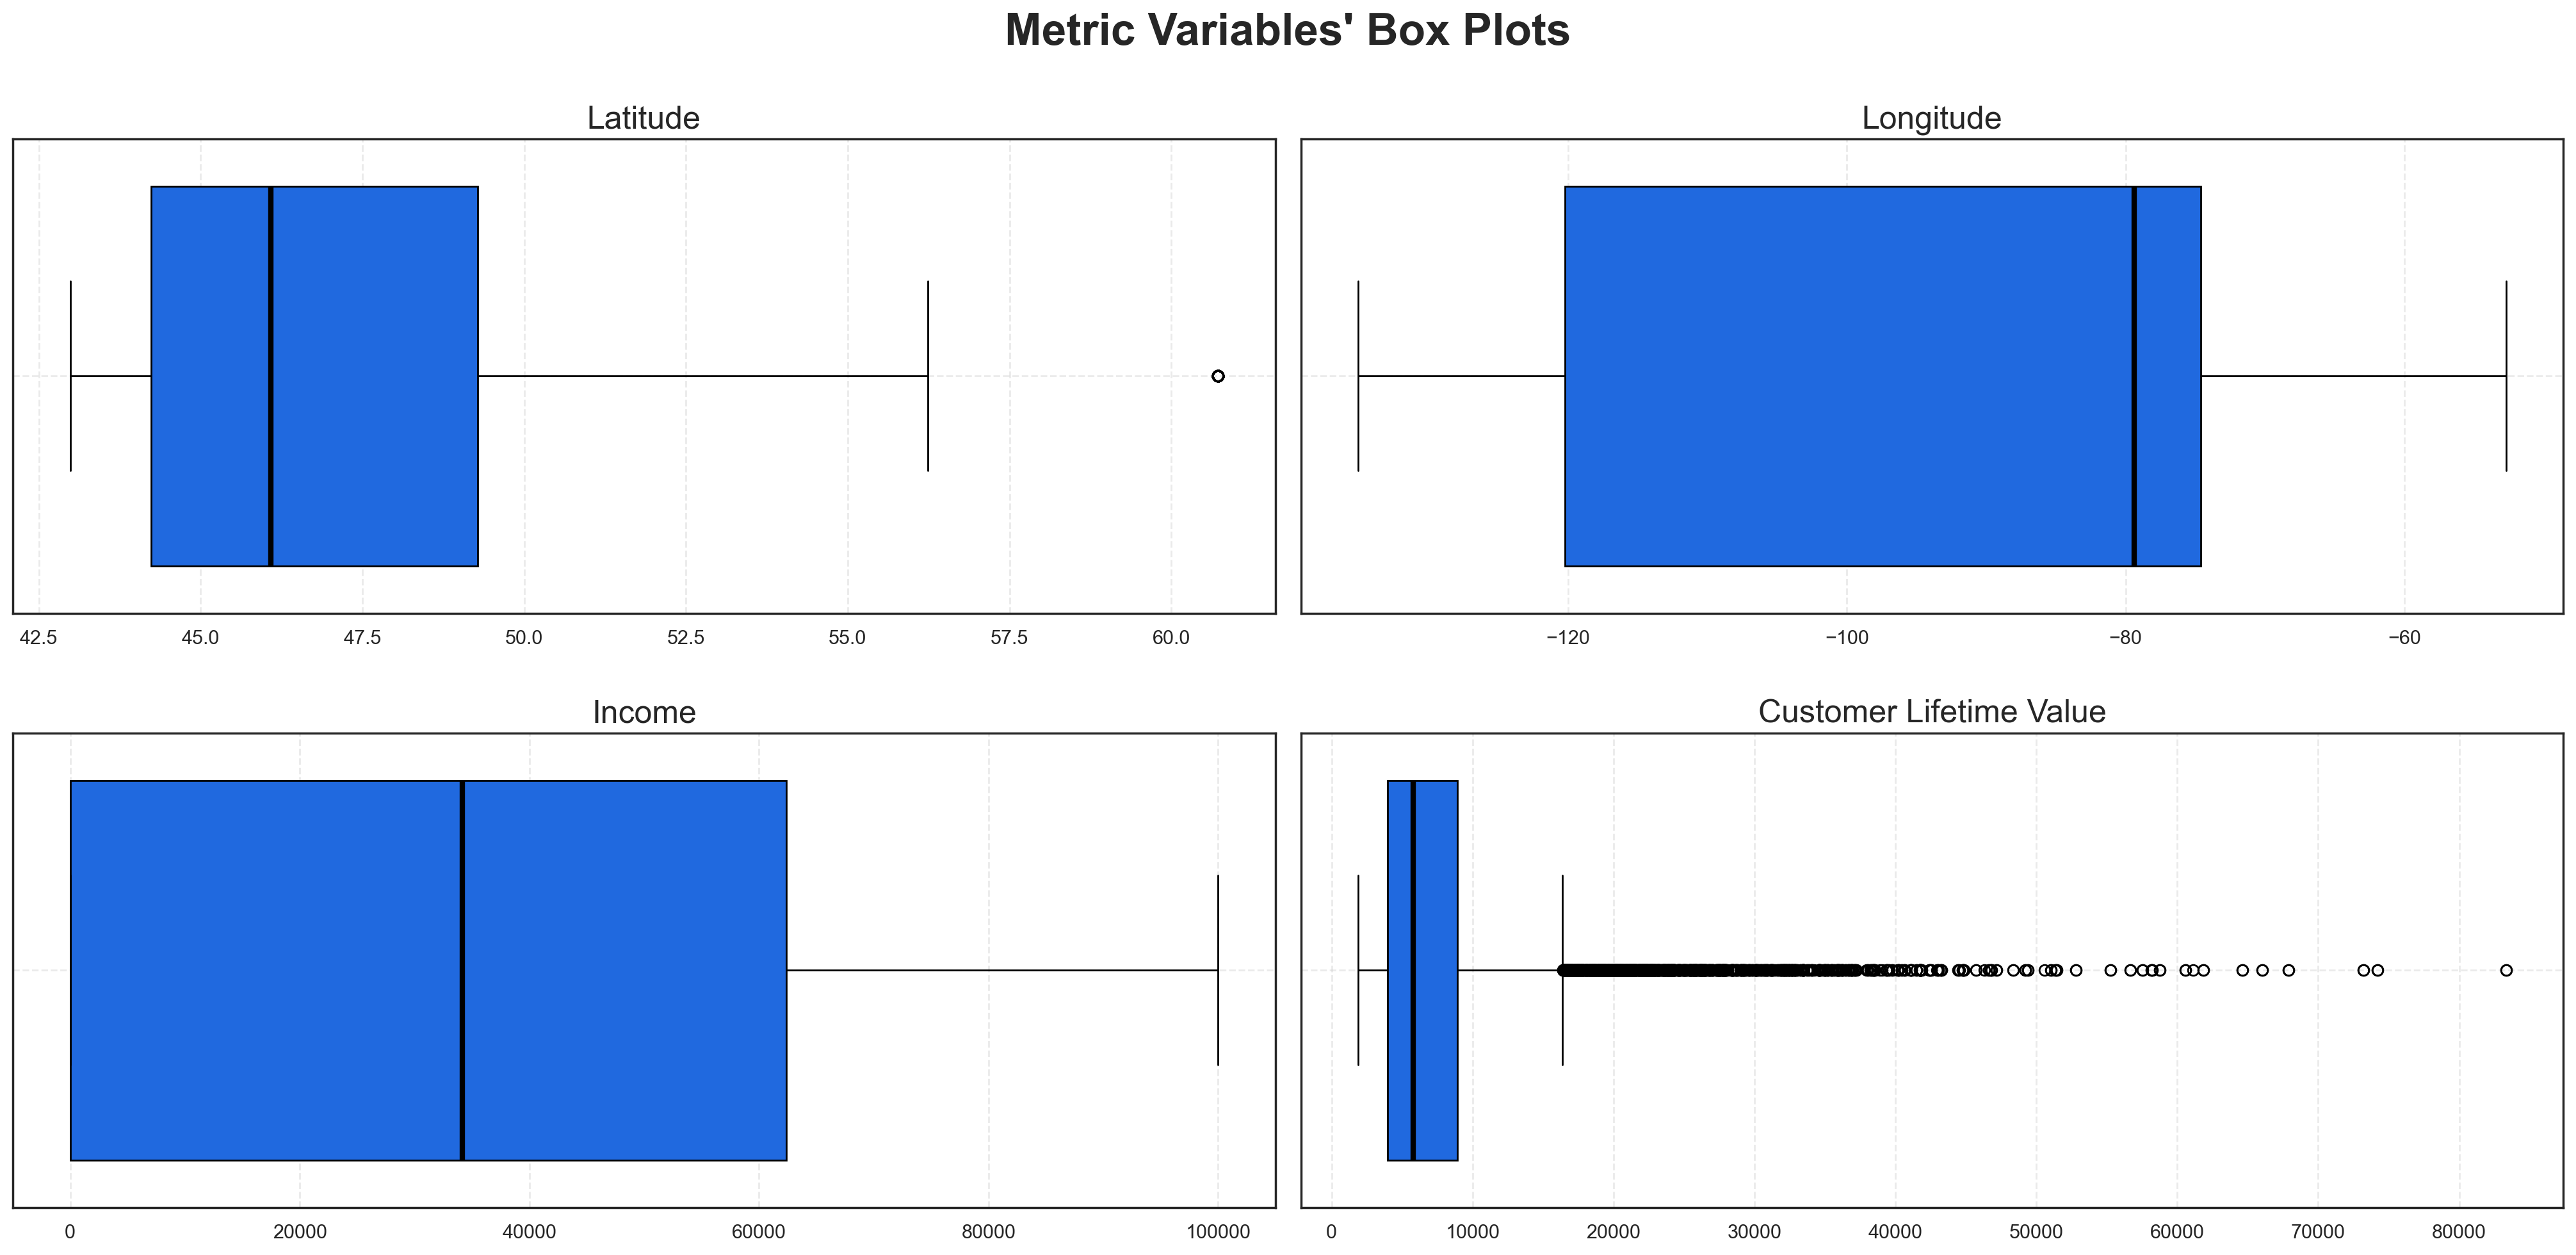

In [ ]:
# Create canvas with the same structure as before
fig, axes = plt.subplots(sp_rows_CDB, 
                         sp_cols_CDB, 
                         figsize=(20, 10),
                         constrained_layout=True) # Adjust automatically spacing between subplot and labels 

# Increase vertical space between rows
fig.set_constrained_layout_pads(h_pad=.2)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features_CDB):
    # We need to reset the index to avoid errors since we haven't dealt with duplicate values yet
    sns.boxplot(x=customerDB[feat].reset_index(drop= True), ax=ax, 
                # Set inside color to blue
                color="#0062FF",
                # Set line colors to black
                boxprops=dict(edgecolor="black"),
                whiskerprops=dict(color="black"),
                capprops=dict(color="black"),
                medianprops=dict(color="black", linewidth=3),
                flierprops=dict(markeredgecolor="black")) 
    
    # Put grid with low opacity and dashed line so it's visible, but not distracting
    ax.grid(True, linestyle="--", alpha=0.4)

    # Put title of each graph with bigger font
    ax.set_title(feat, fontsize=18)

    # Hide x label since we already have the boxlplot title at the top
    ax.set_xlabel("") 

# Layout
# Add a centered title to the figure and plot it
plt.suptitle("Metric Variables' Box Plots", 
             fontsize = 25, fontweight="bold")

# Create the folder '../figures/eda' if it doesn't already exist
os.makedirs(os.path.join('..', 'figures', 'eda'), exist_ok=True)

# Save figure to a png file in the folder created before
plt.savefig(os.path.join('..', 'figures', 'eda', 'numeric_variables_histograms.png'), dpi=200)

# Show plot
plt.show()

From the boxplots above we can conclude that:

- `Latitude:` The values range between ~43-56.5°, with most values on the higher latitudes and one outlier more up north.
- `Longitude:` Values between -140° and -55° with a lot of values on lower longitudes, no outliers.
- The combination of these two features tells us AIA's customers are from North America, more specifically from Canada and the northern states of the USA.
- `Income:` There is a wide range of salaries, a quarter of the customers have income close to zero and another quarter has low-mid income, which pulls the median down and provokes right skewness. No outliers.
- `Customer Lifetime Value:` It's always at least ~1000$ and has a median of around 6000$. Has a very right skewed distribution with lots of outliers that represent the customers that are very profitable and thus important for the company.

## Relationship between metric features (CustomerDB)

### Latitude and Longitude

We reach the conclusion it is very difficult to take conclusions from histograms and boxplots of the variables **Latitude and Longitude**
Since that together they have more meaning, we can plot them in a Scatter plot to see if there are any clusters of coordinates that could represent cities where our customers are concentrated. 

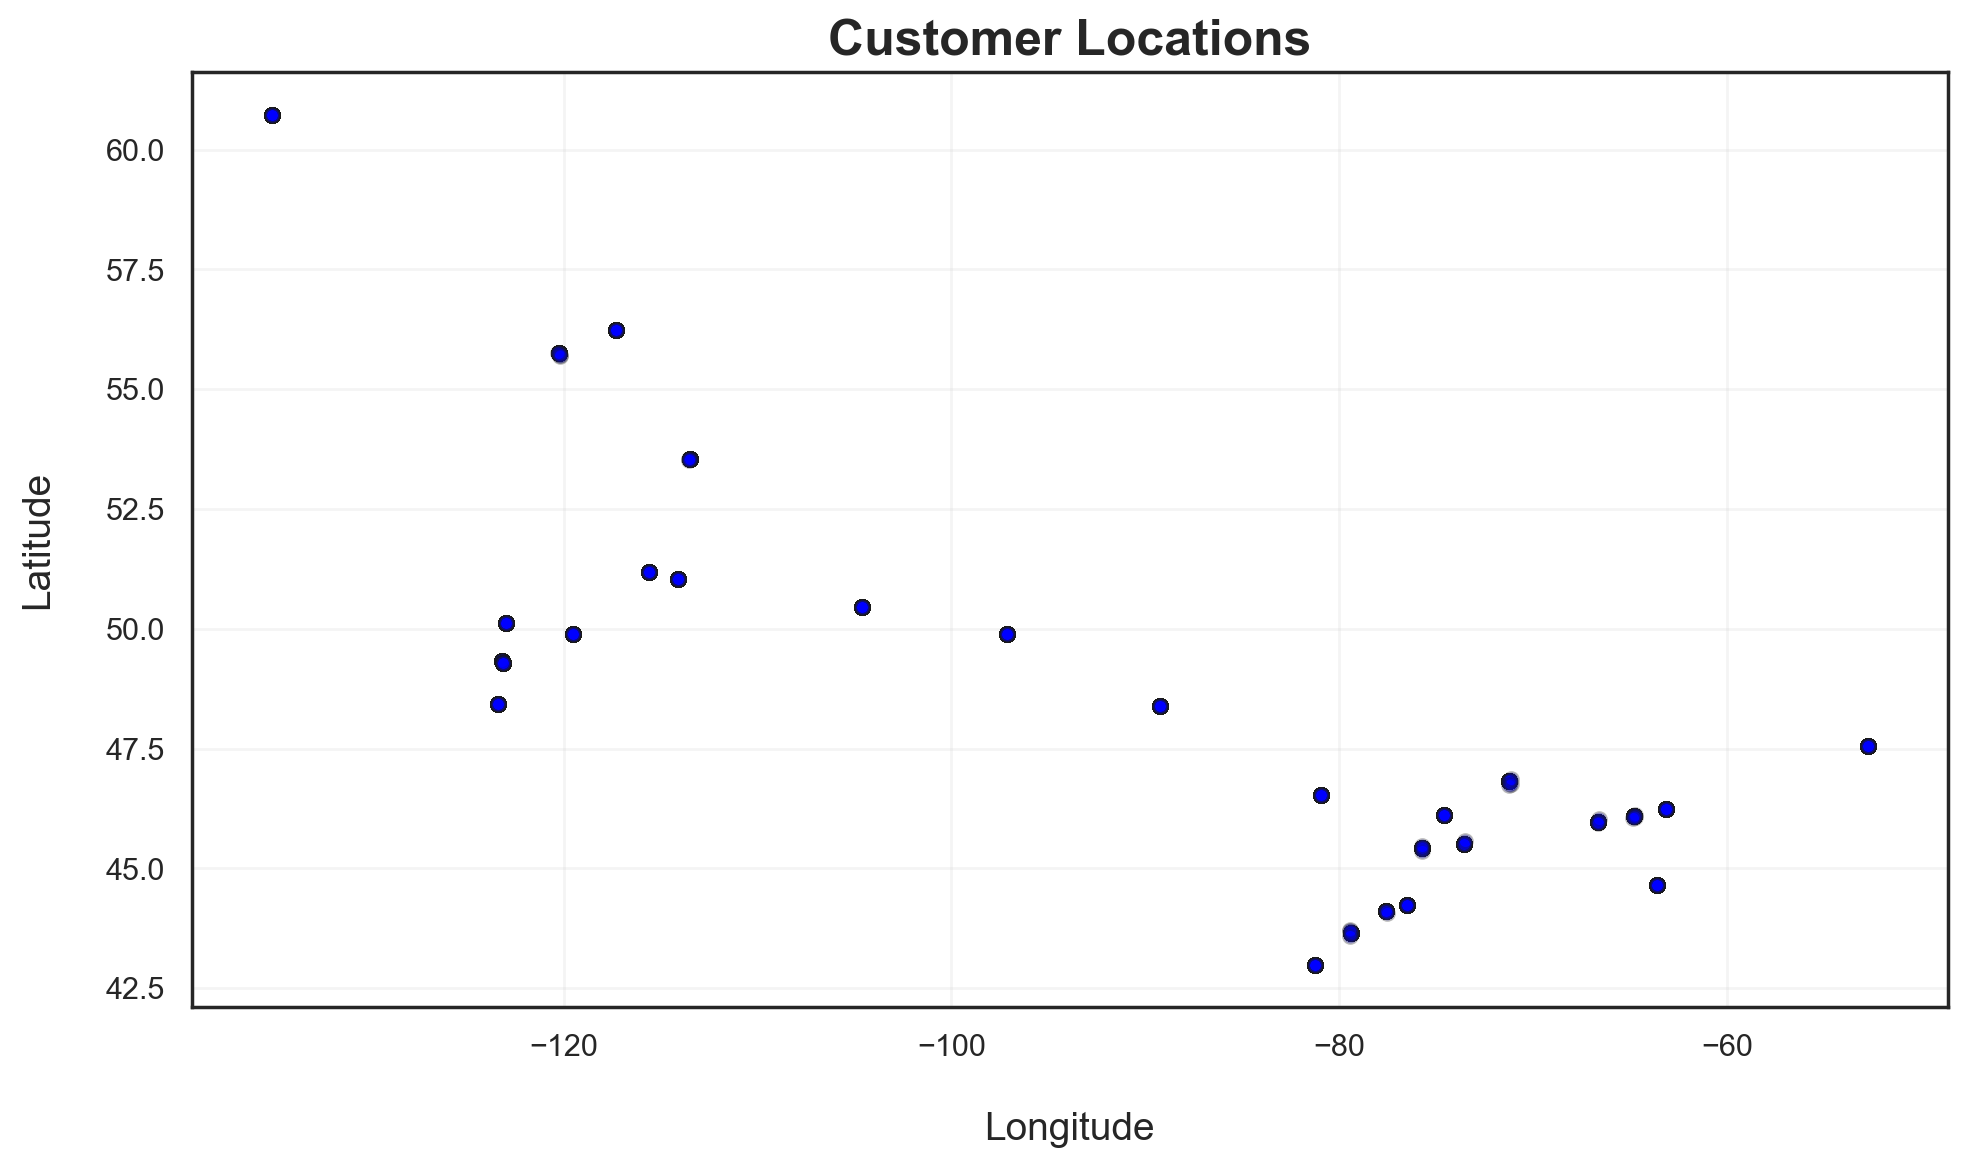

In [ ]:
plt.figure(figsize=(10, 6))

sns.set_style("white")
plt.scatter(
    customerDB["Longitude"], 
    customerDB["Latitude"], 
    s=25,             # Increased point size
    alpha=0.3,
    c='blue',         
    edgecolor='k'
)
plt.title(
    "Customer Locations",
    fontsize=18,      # Larger title
    fontweight='bold' # Bold title
)
plt.xlabel(
    "Longitude",
    fontsize=14,
    labelpad=18       # Bigger axis title
)
plt.ylabel("Latitude",
            fontsize=14,      # Bigger axis title
            labelpad=18)       # Extra space from y-axis

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


The graph is very underwhelming. We were expecting lots of data, but looks like there are very few Latitude-Longitude points, which doesn't allow us to make much conclusions.

In [ ]:
lat_count = customerDB["Latitude"].count()
long_count = customerDB["Longitude"].count()

print(f"Latitude has {lat_count} values.")
print(f"Longitude has {long_count} values.")

Latitude has 16921 values.
Longitude has 16921 values.


In [ ]:
lat_duplicated = customerDB["Latitude"].duplicated().sum()
long_duplicated = customerDB["Longitude"].duplicated().sum()

print(f"The Latitude column has {lat_duplicated} duplicated values, which represents {(lat_duplicated/lat_count*100).round(2)}% of the total data.")
print(f"The Longitude column has {long_duplicated} duplicated values, which represents {(long_duplicated/long_count*100).round(2)}% of the total data.")

The Latitude column has 16872 duplicated values, which represents 99.71% of the total data.
The Longitude column has 16872 duplicated values, which represents 99.71% of the total data.


This explains why we had so few points in the scatter plot. Let's see what exactly are the values.

In [ ]:
customerDB[["Latitude","Longitude"]].value_counts()

Latitude   Longitude  
43.653225  -79.383186     3387
49.282730  -123.120740    2600
45.501690  -73.567253     2064
49.895138  -97.138374      676
50.116322  -122.957360     586
44.648766  -63.575237      541
45.421532  -75.697189      516
53.544388  -113.490930     510
44.101128  -77.576309      490
46.813877  -71.207977      481
55.759628  -120.237660     441
45.963589  -66.643112      432
50.445210  -104.618900     412
44.231171  -76.485954      406
46.118462  -74.596184      399
48.428421  -123.365650     391
45.428730  -75.713364      363
49.328625  -123.160190     315
48.380894  -89.247681      258
47.561508  -52.712578      258
46.522099  -80.953033      229
46.087818  -64.778229      215
51.048615  -114.070850     193
51.178398  -115.570800     190
42.984924  -81.245277      176
56.234180  -117.289380     113
60.721188  -135.056840     112
49.887951  -119.496010      80
46.238239  -63.131069       67
45.365906  -75.723181        1
43.690489  -79.436758        1
55.751178  -120.

By searching what these coordinates represent on Google Maps, we conclude they identify the city the customer is from and not their exact location, probably for privacy reasons.
For example, the first 3 coordinates represent Toronto, Vancouver and Montreal, which are all Canadian cities.

Since we already have a column that represents the name of the city the customer is from, we conclude the **columns for Latitude and Longitude are redundant**.

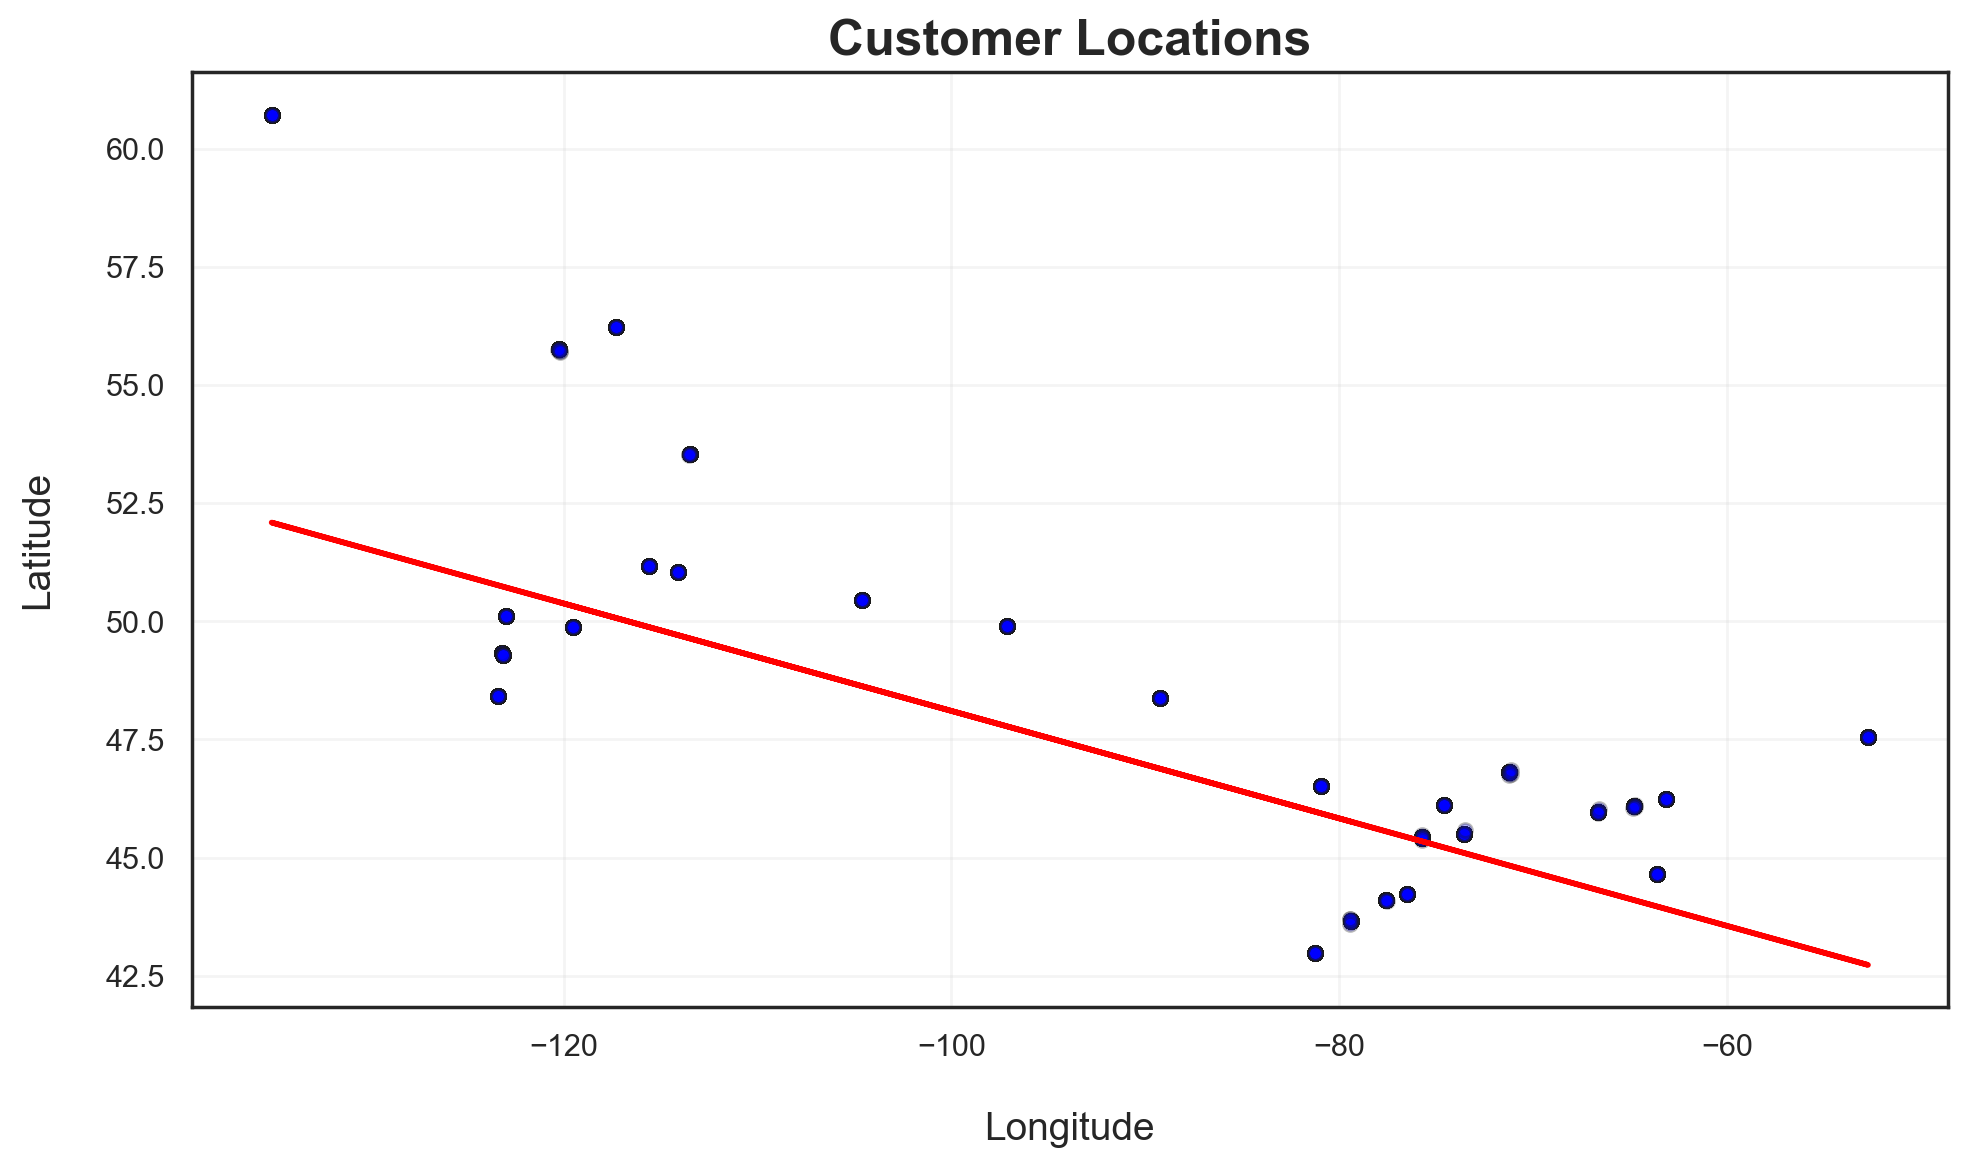

In [ ]:
import numpy as np

x = customerDB["Longitude"]
y = customerDB["Latitude"]

# Scatter plot as before
plt.figure(figsize=(10, 6))
sns.set_style("white")
plt.scatter(x, y, s=25, alpha=0.3, c='blue', edgecolor='k')

# Fit a linear trend line
coeffs = np.polyfit(x, y, 1)
trend = np.poly1d(coeffs)
plt.plot(x, trend(x), color='red', linewidth=2)  # Line

plt.title("Customer Locations", fontsize=18, fontweight='bold')
plt.xlabel("Longitude", fontsize=14, labelpad=18)
plt.ylabel("Latitude", fontsize=14, labelpad=18)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


Plotting a trend line on the scatter plot, we can see a version of the geographic distribution of the cities. From this, we can say there are two main clusters of cities: the ones in the northeast and the ones in the southwest.

The trendline represents a link between the two groups of cities and could represent some routes of the flights taken.

### Income and Customer Lifetime Value

Given the business context, it is important to understand whether a customer's income is linked to their overall value for the company, as measured by Customer Lifetime Value (CLV). By analyzing the relationship between these two variables, we can uncover whether higher-income clients tend to generate more revenue and loyalty over time. Identifying such patterns can guide targeted marketing strategies or segmentation in later project stages.

To ensure the analysis is based on valid and meaningful data, we first removed any records with missing values or zero income. We then use a scatter plot to visualize the association between income and CLV.

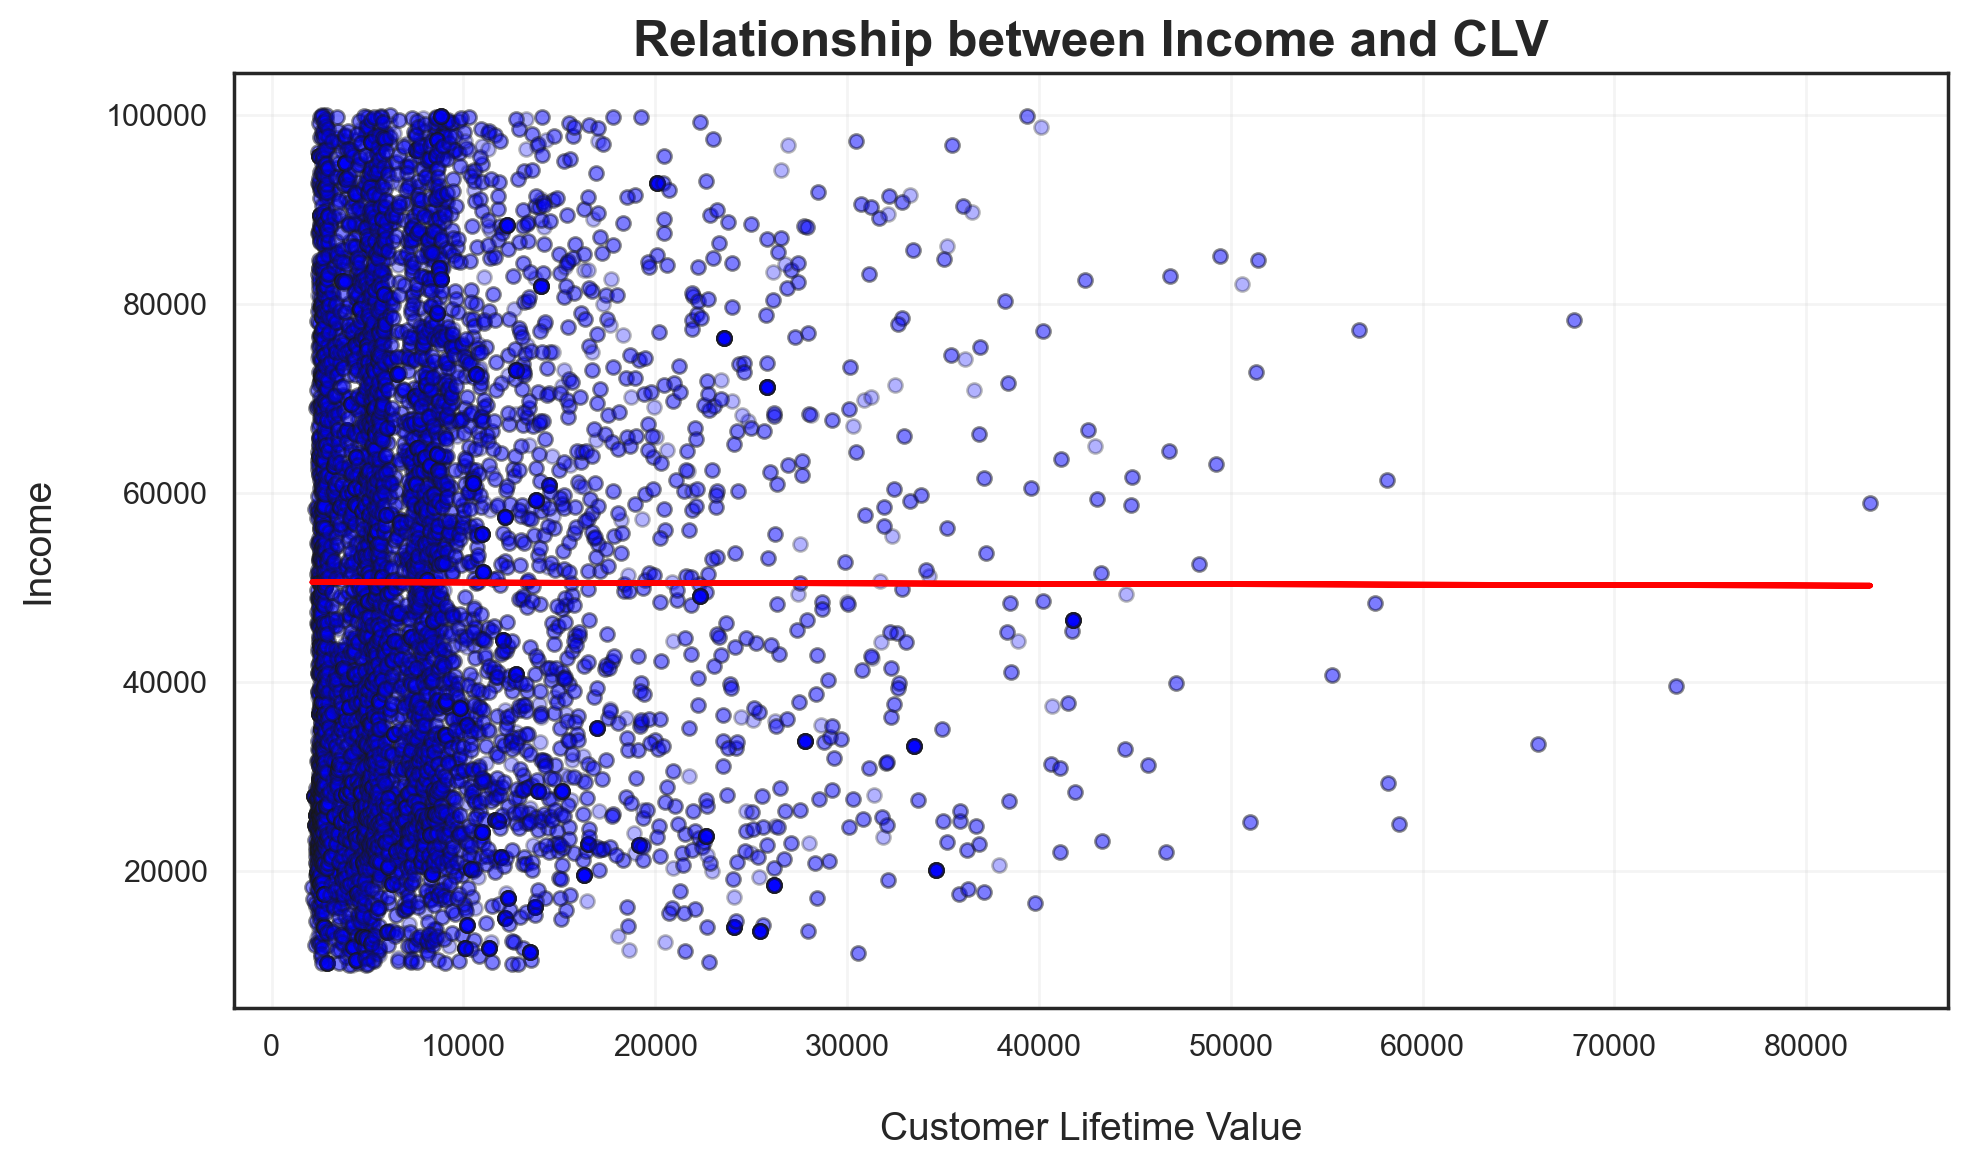

In [ ]:
mask = (
    customerDB["Income"].notna() &
    (customerDB["Income"] > 0) &
    customerDB["Customer Lifetime Value"].notna()
)

income_clean = customerDB.loc[mask, "Income"]
clv_clean = customerDB.loc[mask, "Customer Lifetime Value"]

plt.figure(figsize=(10, 6))
sns.set_style("white")
plt.scatter(clv_clean, income_clean, s=25, alpha=0.3, c='blue', edgecolor='k')

# Fit a linear trend line only on valid data
coeffs = np.polyfit(clv_clean, income_clean, 1)
trend = np.poly1d(coeffs)
plt.plot(clv_clean, trend(clv_clean), color='red', linewidth=2)

plt.title("Relationship between Income and CLV", fontsize=18, fontweight='bold')
plt.xlabel("Customer Lifetime Value", fontsize=14, labelpad=18)
plt.ylabel("Income", fontsize=14, labelpad=18)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


There is no clear relationship between customer income and Customer Lifetime Value (CLV) in this dataset. Across all income levels, there is a wide spread of CLV values, indicating that income is not a predictive factor for overall customer value. This suggests that other factors beyond income drive long-term customer engagement and spending.

## Categorical visualizations (CustomerDB)

Before separating the metric and categorical variables, it was necessary to filter out those that do not provide analytical insights.
Variables such as First Name, Last Name, Customer Name, and Postal Code were excluded, as they act merely as unique identifiers and do not contribute to understanding customer behavior or analytical patterns.
Now we will analyze the features: Gender, Education, Country, Marital Status, Loyalty Status, and Enrollment Type:

/var/folders/_3/5wx2vmw160gc7lnm_w7hs6100000gn/T/ipykernel_43880/3916352460.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=customerDB, ax=axes[row, col], palette="pastel")
/var/folders/_3/5wx2vmw160gc7lnm_w7hs6100000gn/T/ipykernel_43880/3916352460.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=customerDB, ax=axes[row, col], palette="pastel")
/var/folders/_3/5wx2vmw160gc7lnm_w7hs6100000gn/T/ipykernel_43880/3916352460.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=customer

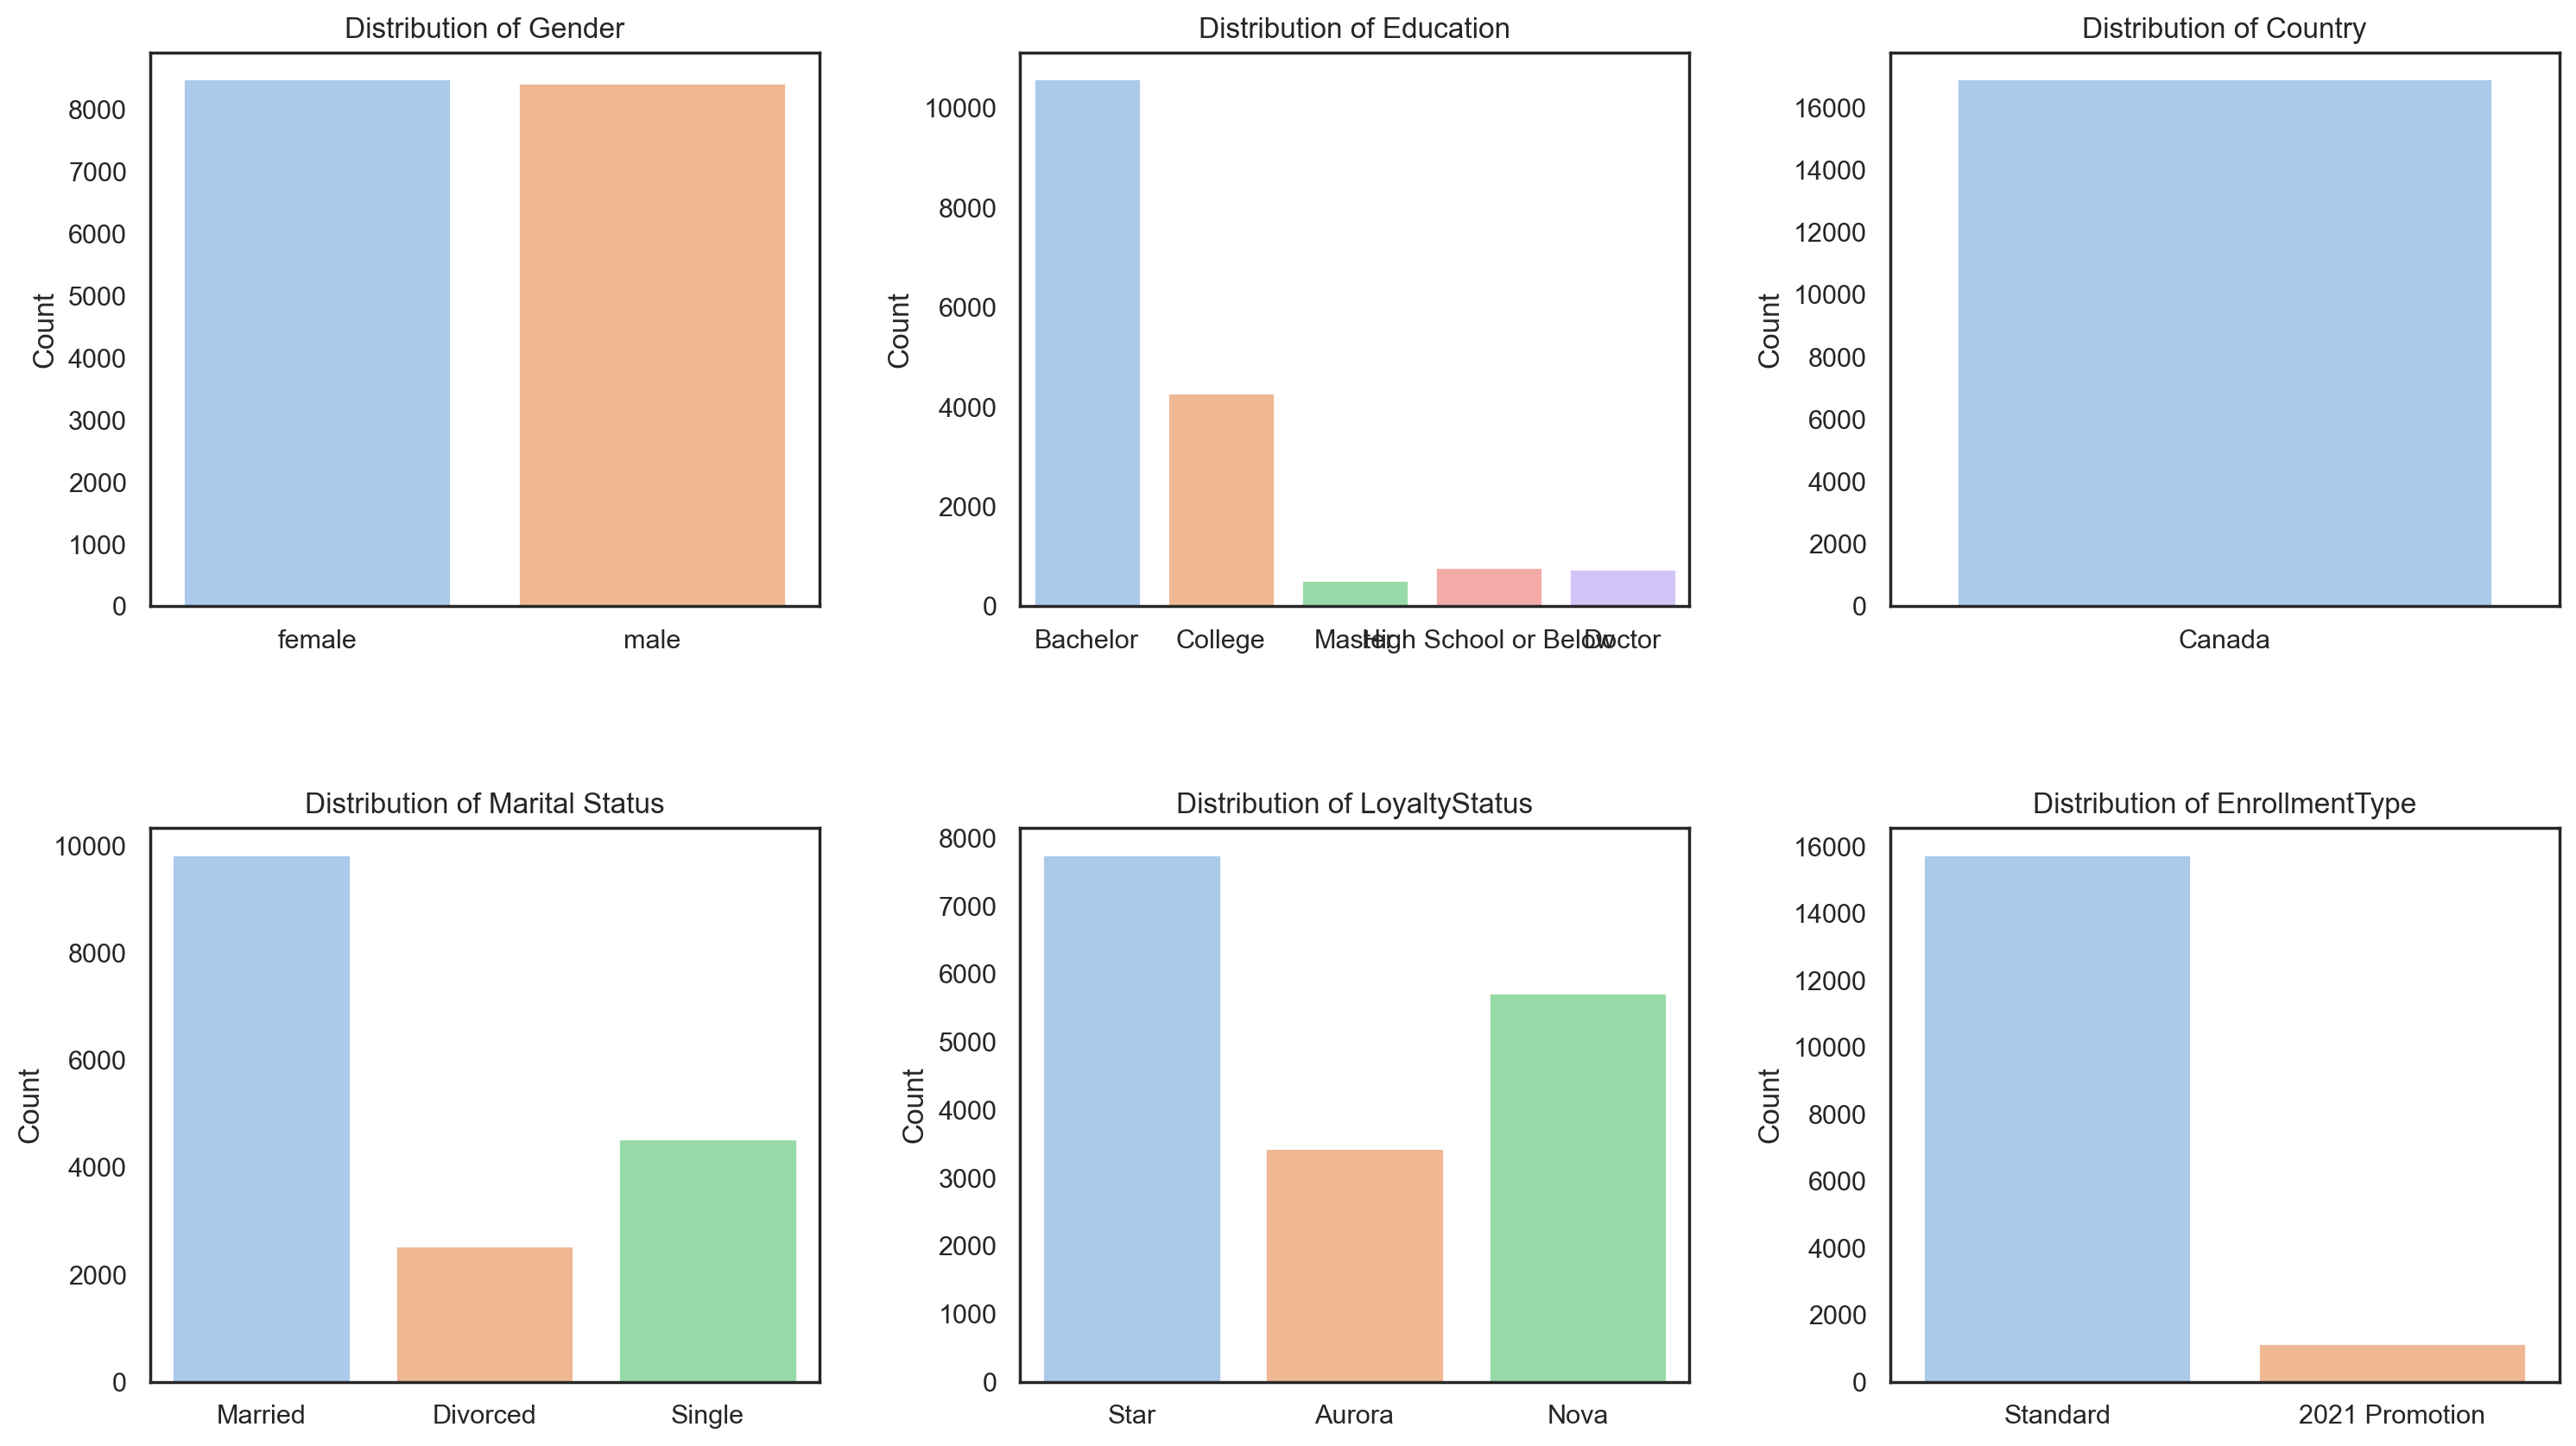

In [15]:
categorical_features = ['Gender', 'Education', 'Country', 'Marital Status', 'LoyaltyStatus', 'EnrollmentType']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))


plt.subplots_adjust(hspace=0.4, wspace=0.3)


for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    sns.countplot(x=feature, data=customerDB, ax=axes[row, col], palette="pastel")
    axes[row, col].set_title(f"Distribution of {feature}", fontsize=12)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Count")

plt.show()

From this, we can see that the data shows customers are mostly Canadian, with a higher education level (bachelor’s degree) and predominantly married. This suggests an adult, stable audience with strong purchasing power, ideal for loyalty strategies and premium offers.

Analysis of the City feature:

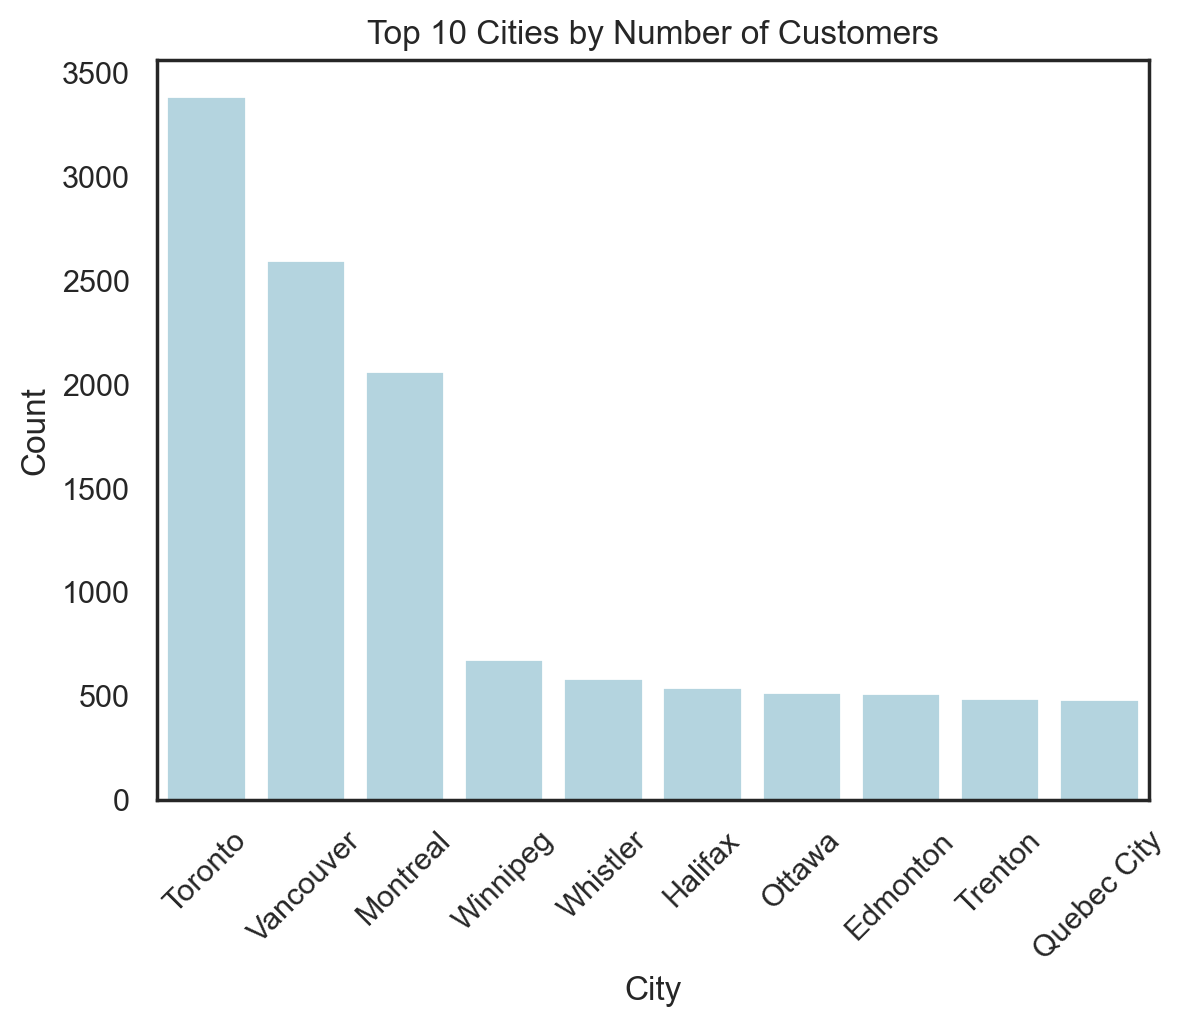

In [ ]:
top_cities = customerDB["City"].value_counts().nlargest(10).index

sns.countplot(
    x="City",
    data=customerDB[customerDB["City"].isin(top_cities)],
    order=top_cities,    
    color="lightblue"
)
plt.title("Top 10 Cities by Number of Customers")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The chart reveals that Toronto, Vancouver, and Montreal are the top three cities with the highest number of customers. This indicates that the company’s customer base is strongly concentrated in major urban centers, particularly in Ontario and Quebec. These cities should therefore be considered key markets for targeted marketing and customer retention initiatives.

Analysis of the EnrollmentDateOpening feature:

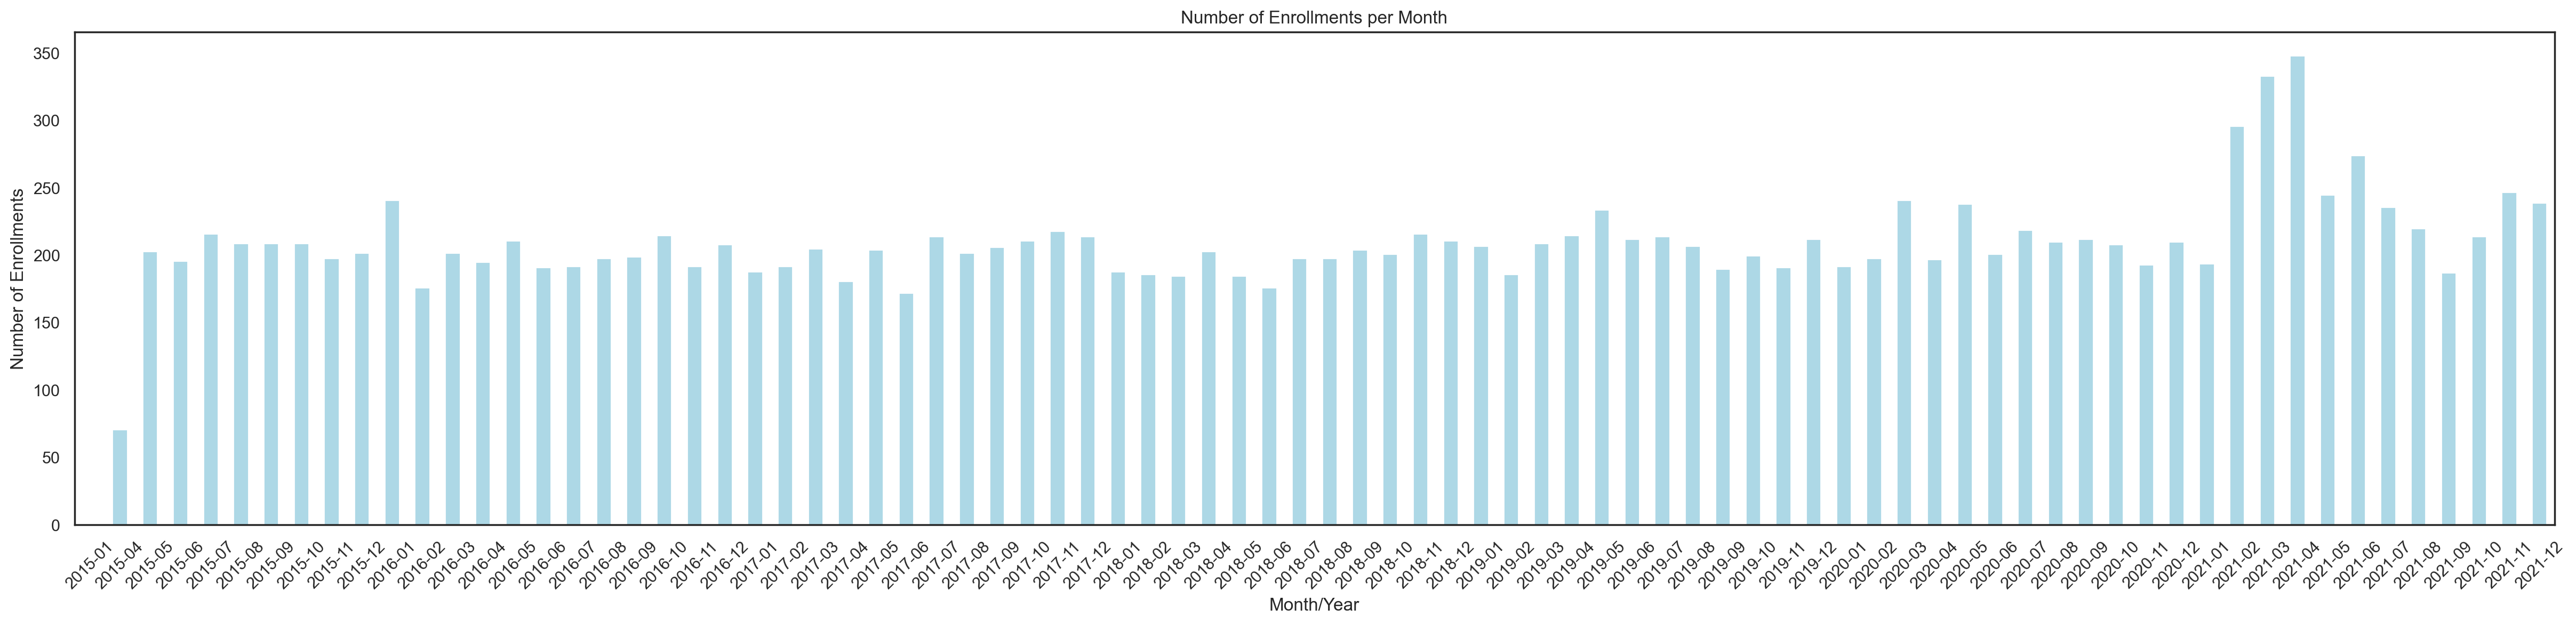

In [17]:
customerDB["EnrollmentDateOpening"] = pd.to_datetime(customerDB["EnrollmentDateOpening"])
monthly_enrollment = customerDB["EnrollmentDateOpening"].dt.to_period("M").value_counts().sort_index()

plt.figure(figsize=(30,6))
monthly_enrollment.plot(kind="bar", color="lightblue")
plt.title("Number of Enrollments per Month")
plt.xlabel("Month/Year")
plt.ylabel("Number of Enrollments")
plt.xticks(rotation=45)
plt.show()

The monthly enrollment data shows a generally stable trend with noticeable peaks towards the end of each year, suggesting periodic increases in customer activity. This pattern may be linked to seasonal promotions or renewal cycles, indicating opportunities to reinforce marketing strategies during these high-demand periods.

# Interactive EDA Dashboard

In [ ]:
# streamlit run app.py --server.headless true 
# Colocar isto no terminal para obter o link do dashboard

## Prerequisit Files

First we need to create .py files to load the data and import the plots.

In [ ]:
%%writefile requirements.txt
streamlit
pandas
matplotlib
seaborn
fastcore


Overwriting requirements.txt


Write data loader file

In [ ]:
%%writefile data_loader.py
import pandas as pd
import os

def load_data():
    """Load FlightsDB, CustomerDB and Metadata CSVs with correct paths."""

    FILE_DIR = os.path.dirname(__file__)  # Folder where this .py file exists
    DATA_DIR = os.path.join(FILE_DIR, "data")  # Data folder next to app.py

    # Build reliable absolute paths
    flights_path = os.path.join(DATA_DIR, "DM_AIAI_FlightsDB.csv")
    customer_path = os.path.join(DATA_DIR, "DM_AIAI_CustomerDB.csv")
    metadata_path = os.path.join(DATA_DIR, "DM_AIAI_Metadata.csv")

    # Load CSVs
    flightsDB = pd.read_csv(flights_path, sep=",", index_col="Loyalty#")
    customerDB = pd.read_csv(customer_path, sep=",", index_col="Loyalty#")
    metaData = pd.read_csv(metadata_path, sep=";", header=None)

    # Feature lists
    non_metric_features_FDB = ["YearMonthDate"]
    metric_features_FDB = flightsDB.columns.drop(non_metric_features_FDB).to_list()
    continuous_FDB = ["DistanceKM", "PointsAccumulated", "PointsRedeemed", "DollarCostPointsRedeemed"]

    metric_features_CDB = customerDB.select_dtypes(include=['number']).columns.tolist()
    continuous_CDB = ["Latitude", "Longitude", "Income", "Customer Lifetime Value"]
    non_metric_features_CDB = customerDB.columns.drop(metric_features_CDB).to_list()

    return (
        flightsDB, customerDB, metaData,
        non_metric_features_FDB, metric_features_FDB, continuous_FDB,
        metric_features_CDB, continuous_CDB, non_metric_features_CDB
    )


Overwriting data_loader.py


Write a file with all the graph functions we will be using on the dashboard.

In [ ]:
%%writefile graph_functions.py
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
import pandas as pd

def boxplots_CDB(df: pd.DataFrame, features: list, rows: int = 2, figsize=(20, 10)):
    """
    Create a matplotlib Figure containing boxplots for the given features from df.
    - df: customer dataframe
    - features: list of numeric feature names to plot
    - rows: preferred number of rows (function will compute columns automatically)
    Returns: matplotlib.figure.Figure
    """
    if not features:
        raise ValueError("No features provided for boxplots.")

    n = len(features)
    cols = ceil(n / rows)

    sns.set_style("white")
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    fig.set_constrained_layout_pads(h_pad=.2)

    # Flatten axes to iterate easily
    if hasattr(axes, "flatten"):
        axes_list = axes.flatten()
    else:
        axes_list = [axes]

    # Hide extra axes if any
    for ax in axes_list[n:]:
        ax.set_visible(False)

    for ax, feat in zip(axes_list, features):
        if feat not in df.columns:
            ax.set_visible(False)
            continue

        data = df[feat].dropna().reset_index(drop=True)
        if data.empty:
            ax.set_visible(False)
            continue

        sns.boxplot(
            x=data,
            ax=ax,
            color="#0062FF",
            boxprops=dict(edgecolor="black"),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            medianprops=dict(color="black", linewidth=3),
            flierprops=dict(markeredgecolor="black")
        )

        ax.grid(True, linestyle="--", alpha=0.4)
        ax.set_title(feat, fontsize=18)
        ax.set_xlabel("")

    plt.suptitle("Metric Variables' Box Plots", fontsize=25, fontweight="bold")
    return fig


def location_scatter_CDB(df: pd.DataFrame, lon_col: str = "Longitude", lat_col: str = "Latitude",
                         show_trend: bool = True, figsize=(10, 6)):
    """
    Scatter plot of Longitude vs Latitude using ALL available points.
    - df: dataframe
    - lon_col, lat_col: column names for longitude & latitude
    - show_trend: whether to fit and show a linear trend line
    Returns: matplotlib.figure.Figure
    """
    if lon_col not in df.columns or lat_col not in df.columns:
        raise KeyError(f"Missing coordinates: expected '{lon_col}' and '{lat_col}' in dataframe.")

    coords = df[[lon_col, lat_col]].dropna()
    if coords.empty:
        raise ValueError("No coordinate data available for scatter plot.")

    x = coords[lon_col].values
    y = coords[lat_col].values

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(x, y, s=25, alpha=0.3, c='blue', edgecolor='k', linewidth=0.3)

    # Trend line if requested and we have variation
    try:
        if show_trend and len(x) >= 2 and np.nanstd(x) > 0 and np.nanstd(y) > 0:
            coeffs = np.polyfit(x, y, 1)
            trend = np.poly1d(coeffs)
            sort_idx = np.argsort(x)
            ax.plot(x[sort_idx], trend(x[sort_idx]), color='red', linewidth=2)
    except Exception:
        pass

    ax.set_title("Customer Locations", fontsize=18, fontweight='bold')
    ax.set_xlabel("Longitude", fontsize=14, labelpad=12)
    ax.set_ylabel("Latitude", fontsize=14, labelpad=12)
    ax.grid(True, alpha=0.2)
    fig.tight_layout()
    return fig


Overwriting graph_functions.py


Install streamlit

In [ ]:
!pip install streamlit streamlit-jupyter


## Write Streamlit Dashboard

Write main streamlit file: app.py

In [ ]:
%%writefile app.py
import streamlit as st
st.set_page_config(layout="wide")

import pandas as pd
from data_loader import load_data
from graph_functions import boxplots_CDB, location_scatter_CDB
import numpy as np

# -------------------------
# Utility helpers
# -------------------------
def clear_all_filters():
    """Clear session state and rerun to reset widgets."""
    st.session_state.clear()
    st.experimental_rerun()

def safe_slider(label, min_val, max_val, key=None):
    """Create a slider only when there's a valid range; otherwise show a message and return None."""
    if pd.isna(min_val) or pd.isna(max_val):
        st.sidebar.write(f"⚠️ Not enough data to filter `{label}`")
        return None
    try:
        imin, imax = int(min_val), int(max_val)
    except Exception:
        try:
            imin, imax = float(min_val), float(max_val)
        except Exception:
            st.sidebar.write(f"⚠️ Cannot create slider for `{label}`")
            return None
    if imin < imax:
        return st.sidebar.slider(label, imin, imax, (imin, imax), key=key)
    else:
        st.sidebar.write(f"⚠️ Not enough variation to filter `{label}`")
        return None

# -------------------------
# Load data
# -------------------------
(
    flightsDB, customerDB, metaData,
    non_metric_features_FDB, metric_features_FDB, continuous_FDB,
    metric_features_CDB, continuous_CDB, non_metric_features_CDB
) = load_data()

# Remove Unnamed: 0 globally if present and from feature lists
for unwanted in ["Unnamed: 0"]:
    if unwanted in customerDB.columns:
        customerDB.drop(columns=[unwanted], inplace=True)
    if unwanted in metric_features_CDB:
        try:
            metric_features_CDB.remove(unwanted)
        except ValueError:
            pass
    if unwanted in continuous_CDB:
        try:
            continuous_CDB.remove(unwanted)
        except ValueError:
            pass

# -------------------------
# Sidebar navigation
# -------------------------
st.sidebar.title("📌 Navigation")
page = st.sidebar.radio("Go to:", ["Customer Explorer", "Flights Explorer", "Insights & Graphs"])

# -------------------------
# PAGE: Customer Explorer
# -------------------------
if page == "Customer Explorer":
    st.title("👤 Customer Database Explorer")
    df = customerDB.copy()

    st.sidebar.subheader("Filters")
    if st.sidebar.button("Clear All Filters"):
        clear_all_filters()

    # Convert date columns
    for date_col in ["EnrollmentDateOpening", "CancellationDate"]:
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    # Date filters
    for col, label in [("EnrollmentDateOpening", "Enrollment Date"), ("CancellationDate", "Cancellation Date")]:
        if col in df.columns:
            min_d, max_d = df[col].min(), df[col].max()
            if not pd.isna(min_d) and not pd.isna(max_d):
                date_range = st.sidebar.date_input(label, (min_d.date(), max_d.date()), key=f"C_{col}")
                if isinstance(date_range, (list, tuple)) and len(date_range) == 2:
                    start = pd.to_datetime(date_range[0])
                    end = pd.to_datetime(date_range[1])
                    df = df[df[col].between(start, end)]

    # Dropdown filters (safe checks for existence)
    filter_cols = {
        "City": "City",
        "Province or State": "Province or State",
        "Gender": "Gender",
        "Education": "Education",
        "Location Code": "Location Code",
        "Marital Status": "Marital Status",
        "Loyalty Status": "LoyaltyStatus",
        "Enrollment Type": "EnrollmentType"
    }
    for label, col in filter_cols.items():
        if col in df.columns:
            opts = sorted(df[col].dropna().unique().tolist())
            sel = st.sidebar.multiselect(label, opts, key=f"C_{col}")
            if sel:
                df = df[df[col].isin(sel)]

    # Income slider
    if "Income" in df.columns:
        rng = safe_slider("Income", df["Income"].min(), df["Income"].max(), key="C_Income")
        if rng is not None:
            df = df[df["Income"].between(rng[0], rng[1])]

    # CLV slider
    if "Customer Lifetime Value" in df.columns:
        rng = safe_slider("Customer Lifetime Value", df["Customer Lifetime Value"].min(), df["Customer Lifetime Value"].max(), key="C_CLV")
        if rng is not None:
            df = df[df["Customer Lifetime Value"].between(rng[0], rng[1])]

    # If empty after filters
    if df.empty:
        st.warning("⚠️ No records match your filters. Clear filters or broaden your selection.")
        st.stop()

    # ---------- KPI cards (Customer)
    kpi1, kpi2 = st.columns(2)
    # Total Customer Lifetime Value
    total_clv = df["Customer Lifetime Value"].sum() if "Customer Lifetime Value" in df.columns else np.nan
    # City mode
    city_mode = df["City"].mode().iloc[0] if ("City" in df.columns and not df["City"].dropna().empty) else "—"

    kpi1.metric("Total Customer Lifetime Value", f"{total_clv:,.0f}")
    kpi2.metric("Most common City", f"{city_mode}")

    st.markdown("### Filtered Customer Data")
    st.dataframe(df, use_container_width=True, height=700)

    # Download
    csv = df.to_csv(index=False).encode("utf-8")
    st.download_button("Download filtered data (CSV)", data=csv, file_name="filtered_customers.csv", mime="text/csv")

# -------------------------
# PAGE: Flights Explorer
# -------------------------
elif page == "Flights Explorer":
    st.title("✈️ Flight Records Explorer")
    df = flightsDB.copy()

    st.sidebar.subheader("Filters")
    if st.sidebar.button("Clear All Filters"):
        clear_all_filters()

    # Date filter
    if "YearMonthDate" in df.columns:
        df["YearMonthDate"] = pd.to_datetime(df["YearMonthDate"], errors="coerce")
        min_d, max_d = df["YearMonthDate"].min(), df["YearMonthDate"].max()
        if not pd.isna(min_d) and not pd.isna(max_d):
            date_range = st.sidebar.date_input("Year / Month", (min_d.date(), max_d.date()), key="F_Date")
            if isinstance(date_range, (list, tuple)) and len(date_range) == 2:
                df = df[df["YearMonthDate"].between(pd.to_datetime(date_range[0]), pd.to_datetime(date_range[1]))]

    # Numeric sliders (only)
    slider_cols = [
        "NumFlights",
        "NumFlightsWithCompanions",
        "DistanceKM",
        "PointsAccumulated",
        "PointsRedeemed",
        "DollarCostPointsRedeemed"
    ]
    for col in slider_cols:
        if col in df.columns:
            rng = safe_slider(col, df[col].min(), df[col].max(), key=f"F_{col}")
            if rng is not None:
                df = df[df[col].between(rng[0], rng[1])]

    if df.empty:
        st.warning("⚠️ No flight records match your filters. Clear filters or broaden your selection.")
        st.stop()

    # --------- KPI cards (Flights)
    f1, f2, f3 = st.columns(3)
    total_flights = int(df["NumFlights"].sum()) if "NumFlights" in df.columns else 0
    total_accum = int(df["PointsAccumulated"].sum()) if "PointsAccumulated" in df.columns else 0
    total_redeemed = int(df["PointsRedeemed"].sum()) if "PointsRedeemed" in df.columns else 0


    f1.metric("Total Number of Flights", f"{total_flights:,}")
    f2.metric("Total Points Accumulated", f"{total_accum:,}")
    f3.metric("Total Points Redeemed", f"{total_redeemed:,}")


    st.markdown("### Filtered Flight Data")
    st.dataframe(df, use_container_width=True, height=700)

    # Download
    csv = df.to_csv(index=False).encode("utf-8")
    st.download_button("Download filtered data (CSV)", data=csv, file_name="filtered_flights.csv", mime="text/csv")

# -------------------------
# PAGE: Insights & Graphs
# -------------------------
elif page == "Insights & Graphs":
    st.title("📊 Customer Insights Dashboard")

    st.sidebar.subheader("Insights Controls (CustomerDB)")

    # Available numeric metrics (safe)
    available_metrics = [c for c in metric_features_CDB if c in customerDB.columns]
    if not available_metrics:
        st.warning("No numeric features found in CustomerDB for plotting.")
    else:
        selected = st.sidebar.multiselect(
            "Select metric features to plot (boxplots)",
            options=available_metrics,
            default=available_metrics[:8]
        )

        if selected:
            # Auto layout rows: choose 2 rows if <=8 else more rows to keep readable
            n = len(selected)
            rows = 2 if n <= 8 else int(np.ceil(n / 4))
            try:
                fig_box = boxplots_CDB(customerDB, selected, rows=rows)
                st.pyplot(fig_box)
            except Exception as e:
                st.error(f"Failed to build boxplots: {e}")

    # Location scatter (plot ALL points)
    st.sidebar.markdown("---")
    show_location = st.sidebar.checkbox("Show customer location scatter", value=True)
    show_trend = st.sidebar.checkbox("Show trend line on location scatter", value=False)

    if show_location:
        if ("Longitude" in customerDB.columns) and ("Latitude" in customerDB.columns):
            try:
                fig_loc = location_scatter_CDB(customerDB, lon_col="Longitude", lat_col="Latitude", show_trend=show_trend)
                st.pyplot(fig_loc)
            except Exception as e:
                st.error(f"Failed to draw location scatter: {e}")
        else:
            st.info("Longitude/Latitude columns not found in CustomerDB; cannot display location scatter.")


Overwriting app.py
